# Initialize Gemini 1.5 Flash Client

In [ ]:
import os
import google.generativeai as genai
from google.colab import userdata

genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

# Create the model
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "application/json",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  generation_config=generation_config,
)

# Utility Functions

In [ ]:
import mimetypes
import time

def upload_to_gemini(path, mime_type=None):
  """Uploads the given file to Gemini.

  See https://ai.google.dev/gemini-api/docs/prompting_with_media
  """
  if mime_type is None:
    mime_type, _ = mimetypes.guess_type(path)
  file = genai.upload_file(path, mime_type=mime_type)
  print(f"Uploaded file '{file.display_name}' as: {file.uri}")
  return file


def wait_for_files_active(files):
  """Waits for the given files to be active.

  Some files uploaded to the Gemini API need to be processed before they can be
  used as prompt inputs. The status can be seen by querying the file's "state"
  field.

  This implementation uses a simple blocking polling loop. Production code
  should probably employ a more sophisticated approach.
  """
  print("Waiting for file processing...")
  for name in (file.name for file in files):
    file = genai.get_file(name)
    while file.state.name == "PROCESSING":
      print(".", end="", flush=True)
      time.sleep(5)
      file = genai.get_file(name)
    if file.state.name != "ACTIVE":
      raise Exception(f"File {file.name} failed to process")
  print("...all files ready")
  print()

In [ ]:
def extract_skill_from_text(text):
  chat_session = model.start_chat(history=[])

  response = chat_session.send_message([
                text,
                "extract skills (just keyword not detail such as \"proficiency in ...\") into python list",
                "example output :\n",
                "```json\n",
                "{\"skills\": [\"NET CORE\", \"ASP.NET CORE MVC framework\", \"C#\", \"object-oriented programming\", \"reusable libraries\", \"Web API\", \"Web Service\", \"JSON\", \"Microsoft SQL Server 2022\", \"TypeScript\", \"CSS\", \"SCSS\", \"HTML\", \"Angular framework\", \"npm\", \"Yarn\", \"Webpack\", \"CQRS pattern\", \"Visual Studio\", \"Azure DevOps\", \"English language\"]}",
                "\n```",
            ])

  return json.loads(response.text)


def extract_skill_from_image(image_path):
  image = upload_to_gemini(image_path)
  wait_for_files_active([image])

  chat_session = model.start_chat(history=[])

  response = chat_session.send_message([
                image,
                "extract skills (just keyword not detail such as \"proficiency in ...\") into python list",
                "example output :\n",
                "```json\n",
                "{\"skills\": [\"NET CORE\", \"ASP.NET CORE MVC framework\", \"C#\", \"object-oriented programming\", \"reusable libraries\", \"Web API\", \"Web Service\", \"JSON\", \"Microsoft SQL Server 2022\", \"TypeScript\", \"CSS\", \"SCSS\", \"HTML\", \"Angular framework\", \"npm\", \"Yarn\", \"Webpack\", \"CQRS pattern\", \"Visual Studio\", \"Azure DevOps\", \"English language\"]}",
                "\n```",
            ])

  return json.loads(response.text)


def extract_skill_from_pdf(pdf_path):
  pdf = upload_to_gemini(pdf_path)
  wait_for_files_active([pdf])

  chat_session = model.start_chat(history=[])

  response = chat_session.send_message([
                pdf,
                "extract skills (just keyword not detail such as \"proficiency in ...\") into python list",
                "example output :\n",
                "```json\n",
                "{\"skills\": [\"NET CORE\", \"ASP.NET CORE MVC framework\", \"C#\", \"object-oriented programming\", \"reusable libraries\", \"Web API\", \"Web Service\", \"JSON\", \"Microsoft SQL Server 2022\", \"TypeScript\", \"CSS\", \"SCSS\", \"HTML\", \"Angular framework\", \"npm\", \"Yarn\", \"Webpack\", \"CQRS pattern\", \"Visual Studio\", \"Azure DevOps\", \"English language\"]}",
                "\n```",
            ])

  return json.loads(response.text)

In [ ]:
import json

def pprint(json_obj):
  print(json.dumps(json_obj, indent=4))

# Extract Skill from Course/Job Description (Text, Image, PDF)

In [ ]:
text = '''CN230 Database System : Basic concepts of database design and the use of database management systems for
applications. Coverage of the relational model, relational algebra, SQL, database design and
relational design principles based on dependencies and normal forms. Additional key database
topics from the design and application-building perspective.'''

pprint(extract_skill_from_text(text))

{
    "skills": [
        "Database Design",
        "Database Management Systems",
        "Relational Model",
        "Relational Algebra",
        "SQL",
        "Relational Design Principles",
        "Dependencies",
        "Normal Forms"
    ]
}


In [ ]:
image_path = 'job_description.jpg'

pprint(extract_skill_from_image(image_path))

Uploaded file 'job_description.jpg' as: https://generativelanguage.googleapis.com/v1beta/files/nxbtg27vdjeg
Waiting for file processing...
...all files ready

{
    "skills": [
        "C#",
        ".NET CORE",
        "ASP.NET CORE MVC",
        "object-oriented programming",
        "Web API",
        "Web Service",
        "JSON",
        "Microsoft SQL Server 2022",
        "TypeScript",
        "CSS",
        "SCSS",
        "HTML",
        "Angular",
        "npm",
        "Yarn",
        "Webpack",
        "CQRS"
    ]
}


In [ ]:
pdf_path = 'CN310-Linux-docker9.pdf'

pprint(extract_skill_from_pdf(pdf_path))

Uploaded file 'CN310-Linux-docker9.pdf' as: https://generativelanguage.googleapis.com/v1beta/files/7zwqd87n7y54
Waiting for file processing...
...all files ready

{
    "skills": [
        "Docker",
        "Docker Compose",
        "Dockerfile",
        "Docker Registry",
        "Mysql",
        "Wordpress",
        "Linux",
        "CI/CD",
        "Microservices",
        "DevOps",
        "Cloud",
        "Virtual Machine",
        "Containers"
    ]
}


# Connect to Graph Database (AuraDB)

In [ ]:
!pip install -q neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 17.2 MB/s eta 0:00:00


In [ ]:
from neo4j import GraphDatabase
from tqdm.notebook import tqdm

# AuraDB config
uri = "neo4j+s://644d2d99.databases.neo4j.io"
auth = ("neo4j", userdata.get('AURADB_PASSWORD'))


def merge_triple(tx, subject, predicate, object, subject_type, object_type):
  tx.run(
        f"MERGE (s:{subject_type} {{name: $subject}}) "
        f"MERGE (o:{object_type} {{name: $object}}) "
        f"MERGE (s)-[:{predicate}]->(o)",
        subject=subject,
        object=object
    )


def get_synonyms(word):
  chat_session = model.start_chat(history=[
      {
        "role": "user",
        "parts": [
          "Give me a Python list of terms related to \"css\" (in software engineering and tech domain) only synonyms, abbreviations, and the full name. all lowercase.",
        ],
      },
      {
        "role": "model",
        "parts": [
          "```json\n",
          "{\"related_terms\": [\"css\", \"cascading style sheets\", \"style sheets\", \"css3\", \"web styles\", \"stylesheet language\"]}",
          "\n```",
        ],
      },
  ])

  response = chat_session.send_message([
                f"Give me a Python list of terms related to \"{word}\" (in software engineering and tech domain) only synonyms, abbreviations, and the full name. all lowercase."
            ])


  return json.loads(response.text)


def add_new_skill(skill_name):
  with GraphDatabase.driver(uri, auth=auth) as driver:
    with driver.session() as session:
      # link the skill with related term nodes
      llm_response = get_synonyms(skill_name)
      print(f'LLM: Related Terms of "{skill_name}" :\n')
      pprint(llm_response)

      if 'related_terms' in llm_response:
        related_terms = llm_response['related_terms']
      else:
        related_terms = llm_response[list(llm_response.keys())[0]]

      for term in tqdm(related_terms, desc=f'Merge related terms of "{skill_name}"'):

        term = term.lower()

        # if term == skill_name: # we need self-loop !!!
        #   continue

        session.execute_write(merge_triple,
                                  subject=term,
                                  predicate='relate',
                                  object=skill_name,
                                  subject_type='Skill',
                                  object_type='Skill')


def check_skill_existence(tx, skill_name):
  result = tx.run("MATCH (s:Skill {name: $skill_name}) RETURN s", skill_name=skill_name)
  return result.single() is not None


def skill_exists(skill_name):
  with GraphDatabase.driver(uri, auth=auth) as driver:
    with driver.session() as session:
      result = session.execute_read(check_skill_existence, skill_name)
      return result


def add_new_course(course_name, skills):
  with GraphDatabase.driver(uri, auth=auth) as driver:
    with driver.session() as session:
      for skill in tqdm(skills, desc=f'Merge Included Skills of "{course_name}"'):

        skill = skill.lower()

        if not skill_exists(skill):
          add_new_skill(skill)

        session.execute_write(merge_triple,
                                  subject=course_name,
                                  predicate='include',
                                  object=skill,
                                  subject_type='Course',
                                  object_type='Skill')


def add_new_job(job_name, skills):
  with GraphDatabase.driver(uri, auth=auth) as driver:
    with driver.session() as session:
      for skill in tqdm(skills, desc=f'Merge Required Skills of "{job_name}"'):

        skill = skill.lower()

        if not skill_exists(skill):
          add_new_skill(skill)

        session.execute_write(merge_triple,
                                  subject=job_name,
                                  predicate='require',
                                  object=skill,
                                  subject_type='Job',
                                  object_type='Skill')

In [ ]:
pprint(get_synonyms('k8s'))

{
    "related_terms": [
        "k8s",
        "kubernetes",
        "kube"
    ]
}


In [ ]:
pprint(get_synonyms('html'))

{
    "related_terms": [
        "html",
        "html5",
        "hypertext markup language",
        "markup language",
        "web page code",
        "website code"
    ]
}


In [ ]:
pprint(get_synonyms('nuxt'))

{
    "related_terms": [
        "nuxt",
        "nuxt.js",
        "nuxtjs",
        "vue framework",
        "ssr",
        "server-side rendering"
    ]
}


In [ ]:
pprint(get_synonyms('srs'))

{
    "related_terms": [
        "srs",
        "software requirements specification",
        "requirements specification",
        "system requirements specification",
        "requirements document",
        "spec"
    ]
}


In [ ]:
pprint(get_synonyms('oop'))

{
    "related_terms": [
        "oop",
        "object oriented programming",
        "object oriented",
        "oo",
        "classes",
        "objects",
        "inheritance",
        "polymorphism",
        "encapsulation",
        "abstraction"
    ]
}


In [ ]:
pprint(get_synonyms('singleton'))

{
    "related_terms": [
        "singleton",
        "singleton pattern",
        "singleton design pattern"
    ]
}


In [ ]:
pprint(get_synonyms('bizagi'))

{
    "related_terms": [
        "bizagi",
        "bizagi bpm suite",
        "bpm",
        "business process management",
        "workflow",
        "process automation"
    ]
}


In [ ]:
pprint(get_synonyms('c#'))

{
    "related_terms": [
        "c#",
        "c sharp",
        "csharp"
    ]
}


In [ ]:
pprint(get_synonyms('.NET'))

{
    "related_terms": [
        ".net",
        "dotnet",
        "net framework",
        "net core",
        ".net maui",
        ".net sdk",
        "asp.net",
        "netstandard"
    ]
}


# Add new job to graph database

In [ ]:
job_name = 'Microsoft Full Stack Developer'
llm_response = extract_skill_from_image('job_description.jpg')

print(f'LLM: Required Skills of "{job_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_job(job_name, skills)

Uploaded file 'job_description.jpg' as: https://generativelanguage.googleapis.com/v1beta/files/z5w7uythr5tr
Waiting for file processing...
...all files ready

LLM: Required Skills of "Microsoft Full Stack Developer" :

{
    "skills": [
        "NET CORE",
        "ASP.NET CORE MVC framework",
        "C#",
        "object-oriented programming",
        "reusable libraries",
        "Web API",
        "Web Service",
        "JSON",
        "Microsoft SQL Server 2022",
        "TypeScript",
        "CSS",
        "SCSS",
        "HTML",
        "Angular framework",
        "npm",
        "Yarn",
        "Webpack",
        "CQRS pattern",
        "Visual Studio",
        "Azure DevOps",
        "English language"
    ]
}



Merge Required Skills of "Microsoft Full Stack Developer":   0%|          | 0/21 [00:00<?, ?it/s]

LLM: Related Terms of "net core" :

{
    "related_terms": [
        "net core",
        ".net core",
        "dotnet core",
        "asp.net core",
        ".net"
    ]
}


Merge related terms of "net core":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "asp.net core mvc framework" :

{
    "related_terms": [
        "asp.net core mvc",
        "asp.net core",
        "mvc",
        "model-view-controller",
        "asp.net mvc",
        "dotnet mvc",
        ".net mvc",
        "asp.net core web application"
    ]
}


Merge related terms of "asp.net core mvc framework":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "c#" :

{
    "related_terms": [
        "c#",
        "c sharp",
        "csharp"
    ]
}


Merge related terms of "c#":   0%|          | 0/3 [00:00<?, ?it/s]

LLM: Related Terms of "object-oriented programming" :

{
    "related_terms": [
        "oop",
        "object oriented programming",
        "objects",
        "classes",
        "inheritance",
        "polymorphism",
        "encapsulation",
        "abstraction",
        "data abstraction",
        "method",
        "constructor",
        "destructor",
        "interface",
        "implementation",
        "overriding",
        "overloading",
        "virtual functions",
        "polymorphic functions"
    ]
}


Merge related terms of "object-oriented programming":   0%|          | 0/18 [00:00<?, ?it/s]

LLM: Related Terms of "reusable libraries" :

{
    "related_terms": [
        "reusable libraries",
        "libraries",
        "code libraries",
        "reusable code",
        "shared libraries",
        "component libraries",
        "module libraries",
        "function libraries",
        "class libraries",
        "packages",
        "modules",
        "components",
        "code reuse",
        "software libraries",
        "pre-built libraries",
        "third-party libraries"
    ]
}


Merge related terms of "reusable libraries":   0%|          | 0/16 [00:00<?, ?it/s]

LLM: Related Terms of "web api" :

{
    "related_terms": [
        "web api",
        "web application programming interface",
        "api",
        "application programming interface",
        "rest api",
        "restful api",
        "http api",
        "webservice",
        "web service"
    ]
}


Merge related terms of "web api":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "json" :

{
    "related_terms": [
        "json",
        "jsn",
        "javascript object notation",
        "web api",
        "data interchange format",
        "data serialization",
        "rest api"
    ]
}


Merge related terms of "json":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "microsoft sql server 2022" :

{
    "related_terms": [
        "microsoft sql server 2022",
        "mssql 2022",
        "mssql",
        "sql server 2022",
        "ms sql server 2022",
        "sql server",
        "relational database management system",
        "rdbms",
        "database server",
        "microsoft sql server"
    ]
}


Merge related terms of "microsoft sql server 2022":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "typescript" :

{
    "related_terms": [
        "typescript",
        "ts",
        "type script"
    ]
}


Merge related terms of "typescript":   0%|          | 0/3 [00:00<?, ?it/s]

LLM: Related Terms of "css" :

{
    "css_related_terms": [
        "css",
        "cascading style sheets",
        "stylesheets",
        "css3",
        "style sheet"
    ]
}


Merge related terms of "css":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "scss" :

{
    "related_terms": [
        "scss",
        "sass",
        "syntactically awesome style sheets"
    ]
}


Merge related terms of "scss":   0%|          | 0/3 [00:00<?, ?it/s]

LLM: Related Terms of "html" :

{
    "related_terms": [
        "html",
        "html5",
        "hypertext markup language",
        "markup language",
        "web page code",
        "web development"
    ]
}


Merge related terms of "html":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "angular framework" :

{
    "related_terms": [
        "angular",
        "angularjs",
        "angular.js",
        "angular framework",
        "angular 2+",
        "angular 2",
        "angular 4",
        "angular 5",
        "angular 6",
        "angular 7",
        "angular 8",
        "angular 9",
        "angular 10",
        "angular 11",
        "angular 12",
        "angular 13",
        "angular 14",
        "angular 15",
        "angular 16",
        "ng"
    ]
}


Merge related terms of "angular framework":   0%|          | 0/20 [00:00<?, ?it/s]

LLM: Related Terms of "npm" :

{
    "related_terms": [
        "npm",
        "node package manager",
        "node modules",
        "package manager"
    ]
}


Merge related terms of "npm":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Related Terms of "yarn" :

{
    "related_terms": [
        "yarn",
        "yarnpkg",
        "yarn package manager"
    ]
}


Merge related terms of "yarn":   0%|          | 0/3 [00:00<?, ?it/s]

LLM: Related Terms of "webpack" :

{
    "webpack_terms": [
        "webpack",
        "module bundler",
        "js bundler",
        "webpack 5",
        "webpack 4"
    ]
}


Merge related terms of "webpack":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "cqrs pattern" :

{
    "related_terms": [
        "cqrs",
        "cqrs pattern",
        "command query responsibility segregation",
        "command query separation",
        "command query responsibility segregation pattern"
    ]
}


Merge related terms of "cqrs pattern":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "visual studio" :

{
    "related_terms": [
        "visual studio",
        "vs",
        "vs code",
        "visual studio code",
        "msvs",
        "microsoft visual studio"
    ]
}


Merge related terms of "visual studio":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "azure devops" :

{
    "azure_devops_terms": [
        "azure devops",
        "azure",
        "devops",
        "azure pipelines",
        "azure boards",
        "azure repos",
        "azure test plans",
        "azure artifacts",
        "tfs",
        "team foundation server"
    ]
}


Merge related terms of "azure devops":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "english language" :

{
    "related_terms": [
        "english",
        "en",
        "english language",
        "eng",
        "british english",
        "american english"
    ]
}


Merge related terms of "english language":   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
course_name = 'CN230 Database System'

course_description = '''CN230 Database System : Basic concepts of database design and the use of database management systems for
applications. Coverage of the relational model, relational algebra, SQL, database design and
relational design principles based on dependencies and normal forms. Additional key database
topics from the design and application-building perspective.'''

llm_response = extract_skill_from_text(course_description)

print(f'LLM: Included Skills of "{course_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_course(course_name, skills)

LLM: Included Skills of "CN230 Database System" :

{
    "skills": [
        "Database Design",
        "Relational Model",
        "Relational Algebra",
        "SQL",
        "Database Management Systems",
        "Relational Design Principles",
        "Dependencies",
        "Normal Forms"
    ]
}



Merge Included Skills of "CN230 Database System":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "database design" :

{
    "related_terms": [
        "database design",
        "db design",
        "data modeling",
        "database modeling",
        "relational database design",
        "rdbms design",
        "schema design",
        "database schema",
        "entity-relationship diagram",
        "erd",
        "conceptual data model",
        "logical data model",
        "physical data model",
        "data dictionary",
        "normalization",
        "denormalization",
        "database architecture",
        "database management system design",
        "dbms design"
    ]
}


Merge related terms of "database design":   0%|          | 0/19 [00:00<?, ?it/s]

LLM: Related Terms of "relational model" :

{
    "related_terms": [
        "relational model",
        "relational database",
        "rdbms",
        "sql database",
        "relational database management system"
    ]
}


Merge related terms of "relational model":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "relational algebra" :

{
    "related_terms": [
        "relational algebra",
        "ra",
        "relational calculus",
        "database algebra",
        "relational model"
    ]
}


Merge related terms of "relational algebra":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "sql" :

{
    "related_terms": [
        "sql",
        "structured query language",
        "sequel",
        "sql database",
        "relational database",
        "rdbms"
    ]
}


Merge related terms of "sql":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "database management systems" :

{
    "related_terms": [
        "database management systems",
        "dbms",
        "database system",
        "data management system",
        "relational database",
        "rdbms",
        "nosql",
        "sql",
        "database",
        "db"
    ]
}


Merge related terms of "database management systems":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "relational design principles" :

{
    "related_terms": [
        "relational design principles",
        "rdbms design",
        "database design principles",
        "relational database design",
        "normalization",
        "denormalization",
        "functional dependency",
        "candidate key",
        "primary key",
        "foreign key",
        "referential integrity",
        "atomicity",
        "consistency",
        "isolation",
        "durability",
        "acid properties",
        "first normal form",
        "second normal form",
        "third normal form",
        "boyce-codd normal form",
        "fourth normal form",
        "fifth normal form",
        "database normalization",
        "data integrity",
        "data redundancy",
        "relational model"
    ]
}


Merge related terms of "relational design principles":   0%|          | 0/26 [00:00<?, ?it/s]

LLM: Related Terms of "dependencies" :

{
    "related_terms": [
        "dependencies",
        "dependency",
        "deps",
        "external libraries",
        "required libraries",
        "modules",
        "packages",
        "software dependencies",
        "project dependencies",
        "runtime dependencies",
        "build dependencies",
        "development dependencies",
        "direct dependencies",
        "transitive dependencies"
    ]
}


Merge related terms of "dependencies":   0%|          | 0/14 [00:00<?, ?it/s]

LLM: Related Terms of "normal forms" :

{
    "related_terms": [
        "normal forms",
        "nf",
        "1nf",
        "first normal form",
        "2nf",
        "second normal form",
        "3nf",
        "third normal form",
        "bcnf",
        "boyce-codd normal form",
        "4nf",
        "fourth normal form",
        "5nf",
        "fifth normal form",
        "6nf",
        "sixth normal form",
        "database normalization",
        "data normalization"
    ]
}


Merge related terms of "normal forms":   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
job_name = 'Database Administrator'

job_description = '''National ITMX (Interbank Transaction Management and Exchange) is a private company founded by cooperation of Thais Bank to create and provide the national core infrastructure electronics payment to support electronic commerce, payment systems and interbank transaction. We offer ranges of services such as PromptPay, Single and Bulk payment, ATM, Local switching, National Single Bank gateway, Card fraud monitoring & detections services, Cross border transactions and the national core infrastructure and network to supports all Thai banks for all interbank transactions

We are looking for Java Developer role is an integral part of the Payments Technology team within the Banking Solutions Technology organization. The individual will be part of team to develop our next generation of Payments and Transfers services.



Job Descriptions:

 Install, configure, and upgrade Oracle database software and related products.
Monitor database performance, implement changes, and apply new patches and versions when required.
Optimize database performance through tuning and query optimization.
Manage database storage and capacity planning to ensure uninterrupted services.
Create and maintain database documentation, including data models, schemas, and configurations.
Perform regular database backup and recovery operations, ensuring data integrity and security.
Troubleshoot and resolve database issues promptly to minimize downtime.
Collaborate with development and IT teams to design and implement database solutions for new and existing applications.
Implement and enforce database security policies and practices.
Support disaster recovery and business continuity plans related to database systems.
Able to Communicate in English



Qualifications:

At least 2 years of experience in database administrator, and database management.
Strong problem-solving and critical thinking abilities.
Excellent communication and teamwork skills.
Obtained Degree in Computer Science, Computer Engineering, Information Technology or related fields.
Experience with Oracle databases.'''


llm_response = extract_skill_from_text(job_description)

print(f'LLM: Required Skills of "{job_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_job(job_name, skills)

LLM: Required Skills of "Database Administrator" :

{
    "skills": [
        "Oracle database",
        "database administration",
        "database management",
        "database performance monitoring",
        "database tuning",
        "query optimization",
        "database storage management",
        "capacity planning",
        "database documentation",
        "data modeling",
        "database backup and recovery",
        "database troubleshooting",
        "database security",
        "disaster recovery",
        "business continuity planning",
        "problem-solving",
        "critical thinking",
        "communication",
        "teamwork",
        "English"
    ]
}



Merge Required Skills of "Database Administrator":   0%|          | 0/20 [00:00<?, ?it/s]

LLM: Related Terms of "oracle database" :

{
    "related_terms": [
        "oracle database",
        "oracle",
        "oradb",
        "oracle db",
        "database",
        "relational database",
        "rdbms",
        "oracle rdbms",
        "sql database"
    ]
}


Merge related terms of "oracle database":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "database administration" :

{
    "related_terms": [
        "database administration",
        "dba",
        "db admin",
        "database administrator",
        "data administrator",
        "data management",
        "relational database management",
        "rdbms",
        "database management system",
        "dbms"
    ]
}


Merge related terms of "database administration":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "database management" :

{
    "related_terms": [
        "database management",
        "dbms",
        "database system",
        "database management system",
        "relational database",
        "rdbms",
        "sql",
        "nosql",
        "data management",
        "db",
        "database",
        "r dbms",
        "data modeling",
        "data warehousing",
        "data mining"
    ]
}


Merge related terms of "database management":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Related Terms of "database performance monitoring" :

{
    "related_terms": [
        "database performance monitoring",
        "dbpm",
        "database monitoring",
        "db monitoring",
        "performance monitoring",
        "database performance",
        "database health",
        "sql performance",
        "database tuning",
        "query optimization",
        "index optimization",
        "performance analysis",
        "database diagnostics",
        "dbms performance",
        "transaction monitoring",
        "query performance",
        "slow query analysis",
        "wait event analysis",
        "resource utilization",
        "cpu utilization",
        "io utilization",
        "memory utilization",
        "deadlocks",
        "blocking",
        "latency",
        "throughput",
        "response time",
        "query execution time"
    ]
}


Merge related terms of "database performance monitoring":   0%|          | 0/28 [00:00<?, ?it/s]

LLM: Related Terms of "database storage management" :

{
    "related_terms": [
        "database storage management",
        "dbms",
        "database management system",
        "data storage",
        "database administration",
        "data management",
        "storage management",
        "db",
        "database",
        "relational database",
        "rdbms",
        "nosql",
        "cloud storage",
        "data warehousing",
        "data lake",
        "data governance"
    ]
}


Merge related terms of "database storage management":   0%|          | 0/16 [00:00<?, ?it/s]

LLM: Related Terms of "capacity planning" :

{
    "related_terms": [
        "capacity planning",
        "capacity management",
        "cap planning",
        "resource planning",
        "demand planning",
        "performance planning",
        "scaling",
        "sizing"
    ]
}


Merge related terms of "capacity planning":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "database documentation" :

{
    "related_terms": [
        "database documentation",
        "db documentation",
        "database docs",
        "db docs",
        "schema documentation",
        "database schema",
        "data dictionary",
        "data model documentation",
        "erd",
        "entity relationship diagram",
        "database design document",
        "ddl",
        "data definition language",
        "database blueprint",
        "database specification"
    ]
}


Merge related terms of "database documentation":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Related Terms of "database backup and recovery" :

{
    "related_terms": [
        "database backup and recovery",
        "backup and restore",
        "db backup",
        "database recovery",
        "data backup",
        "data recovery",
        "backup",
        "restore",
        "rpo",
        "recovery point objective",
        "rto",
        "recovery time objective",
        "full backup",
        "incremental backup",
        "differential backup",
        "transaction log backup",
        "point-in-time recovery",
        "pitr",
        "disaster recovery",
        "dr",
        "high availability",
        "ha",
        "backup retention policy",
        "sql server backup",
        "oracle backup",
        "mysql backup",
        "postgresql backup"
    ]
}


Merge related terms of "database backup and recovery":   0%|          | 0/27 [00:00<?, ?it/s]

LLM: Related Terms of "database troubleshooting" :

{
    "related_terms": [
        "database troubleshooting",
        "db troubleshooting",
        "database repair",
        "database recovery",
        "sql troubleshooting",
        "sql diagnostics",
        "database diagnostics",
        "db recovery",
        "db repair",
        "database maintenance",
        "relational database troubleshooting",
        "nosql database troubleshooting",
        "data recovery",
        "data repair",
        "database performance tuning",
        "query optimization",
        "index optimization",
        "deadlock detection",
        "connection pooling",
        "transaction management",
        "backup and restore"
    ]
}


Merge related terms of "database troubleshooting":   0%|          | 0/21 [00:00<?, ?it/s]

LLM: Related Terms of "database security" :

{
    "related_terms": [
        "database security",
        "db security",
        "sql injection",
        "data breach",
        "database encryption",
        "access control",
        "authentication",
        "authorization",
        "data loss prevention",
        "dlp",
        "intrusion detection",
        "ids",
        "intrusion prevention",
        "ips",
        "security auditing",
        "data masking",
        "database vulnerability",
        "privilege escalation",
        "sql injection prevention",
        "data sanitization"
    ]
}


Merge related terms of "database security":   0%|          | 0/20 [00:00<?, ?it/s]

LLM: Related Terms of "business continuity planning" :

{
    "related_terms": [
        "business continuity planning",
        "bcp",
        "disaster recovery planning",
        "drp",
        "business continuity",
        "bc",
        "disaster recovery",
        "dr",
        "continuity planning",
        "incident management",
        "crisis management",
        "high availability",
        "ha",
        "business resumption planning",
        "brp"
    ]
}


Merge related terms of "business continuity planning":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Related Terms of "problem-solving" :

{
    "related_terms": [
        "problem-solving",
        "troubleshooting",
        "debugging",
        "root cause analysis",
        "rca",
        "issue resolution",
        "incident management",
        "problem determination",
        "defect resolution",
        "bug fixing",
        "software repair",
        "maintenance",
        "patching"
    ]
}


Merge related terms of "problem-solving":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "critical thinking" :

{
    "related_terms": [
        "critical thinking",
        "problem solving",
        "analytical thinking",
        "logical reasoning",
        "systems thinking",
        "root cause analysis",
        "rca",
        "debugging",
        "troubleshooting",
        "design thinking",
        "heuristic evaluation"
    ]
}


Merge related terms of "critical thinking":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "communication" :

{
    "related_terms": [
        "communication",
        "comms",
        "data communication",
        "network communication",
        "interprocess communication",
        "ipc",
        "rpc",
        "remote procedure call",
        "api",
        "application programming interface",
        "messaging",
        "signal",
        "socket",
        "protocol",
        "transfer"
    ]
}


Merge related terms of "communication":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Related Terms of "teamwork" :

{
    "related_terms": [
        "teamwork",
        "collaboration",
        "cooperation",
        "team effort",
        "group work",
        "coordination",
        "partnership",
        "synergy",
        "joint effort"
    ]
}


Merge related terms of "teamwork":   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
'''
MATCH (course:Course)-[a:include]->(skill3:Skill)-[b:relate]->(skill1:Skill)<-[c:relate]-(skill2:Skill)<-[d:require]-(job:Job)
RETURN course, skill1, skill2, skill3, job, a, b, c, d
'''

In [ ]:
def find_course_job_paths(job_name):
  with GraphDatabase.driver(uri, auth=auth) as driver:
    with driver.session() as session:
      result = session.execute_read(_find_course_job_paths, job_name)
      return result

def _find_course_job_paths(tx, job_name):
  query = (
      "MATCH (course:Course)-[:include]->(skill3:Skill)-[:relate]->(skill1:Skill)<-[:relate]-(skill2:Skill)<-[:require]-(job:Job {name: $job_name}) "
      "RETURN course, skill3, skill1, skill2, job"
  )
  result = tx.run(query, job_name=job_name)
  return [record for record in result]

def find_course_job_paths2(job_name):
  with GraphDatabase.driver(uri, auth=auth) as driver:
    with driver.session() as session:
      result = session.execute_read(_find_course_job_paths2, job_name)
      return result

def _find_course_job_paths2(tx, job_name):
  query = (
      "MATCH (course:Course)-[:include]->(skill1:Skill)<-[:require]-(job:Job {name: $job_name}) "
      "RETURN course, skill1, job"
  )
  result = tx.run(query, job_name=job_name)
  return [record for record in result]

In [ ]:
def describe_course_job_path(path):
  course_name = path["course"]["name"]
  skill3 = path["skill3"]["name"]
  skill1 = path["skill1"]["name"]
  skill2 = path["skill2"]["name"]
  job_name = path["job"]["name"]

  if skill3 == skill1 == skill2:
    description = f'เพราะวิชานี้สอน <i style="color:#CCCCFF;">{skill3.title()}</i> ซึ่ง require ในงาน <b style="color:rgb(116,238,21);">{job_name}</b>'
  elif skill3 == skill1:
    description = f'เพราะวิชานี้สอน <i style="color:#CCCCFF;">{skill3.title()} -> ซึ่งเกี่ยวข้องกับ -> {skill2.title()}</i> ซึ่ง require ในงาน <b style="color:rgb(116,238,21);">{job_name}</b>'
  elif skill1 == skill2:
    description = f'เพราะวิชานี้สอน <i style="color:#CCCCFF;">{skill3.title()} -> ซึ่งเกี่ยวข้องกับ -> {skill2.title()}</i> ซึ่ง require ในงาน <b style="color:rgb(116,238,21);">{job_name}</b>'
  else:
    description = f'เพราะวิชานี้สอน <i style="color:#CCCCFF;">{skill3.title()} -> ซึ่งเกี่ยวข้องกับ -> {skill1.title()} -> ซึ่งเกี่ยวข้องกับ -> {skill2.title()}</i> ซึ่ง require ในงาน <b style="color:rgb(116,238,21);">{job_name}</b>'

  return course_name, description, skill2

def describe_course_job_path2(path):
  course_name = path["course"]["name"]
  skill1 = path["skill1"]["name"]
  job_name = path["job"]["name"]

  description = f'เพราะวิชานี้สอน <i style="color:#CCCCFF;">{skill1.title()}</i> ซึ่ง require ในงาน <b style="color:rgb(116,238,21);">{job_name}</b>'

  return course_name, description, skill1

In [ ]:
def get_all_required_skills(job_name):
  with GraphDatabase.driver(uri, auth=auth) as driver:
    with driver.session() as session:
      result = session.execute_read(_get_all_required_skills, job_name)
      return result

def _get_all_required_skills(tx, job_name):
  query = (
      "MATCH (job:Job {name: $job_name})-[:require]->(skill:Skill) "
      "RETURN skill"
  )
  result = tx.run(query, job_name=job_name)
  return [record['skill']['name'] for record in result]

In [ ]:
from IPython.display import HTML

job_name = 'Database Administrator'
paths = find_course_job_paths(job_name)
paths2 = find_course_job_paths2(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

if paths2:
  for path in paths2:
    course_name, description, skill1 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill1] = True

to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

for k, v in results.items():
  to_be_print.append(f'💠 <b>{k}</b> :')
  for item in v:
    to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
for k, v in required_skills_checklist.items():
  to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))

In [ ]:
# https://tupine.engr.tu.ac.th/programme/soft_en

courses = {
    'CN230 Database System': '''CN230 Database System : Basic concepts of database design and the use of database management systems for
applications. Coverage of the relational model, relational algebra, SQL, database design and
relational design principles based on dependencies and normal forms. Additional key database
topics from the design and application-building perspective.''',

    'SF211 Object-Oriented Programming': '''Introduction to object-oriented programming. Class, Object, Encapsulation, Inheritance,
Polymorphism, and Abstraction.''',

    'SF222 Software Engineering Models and Analysis': '''In this course, students will learn about software modeling and its principles. The
course explains all types of models (Information modeling, Behavioral modeling, and structural
modeling). It teaches syntax, semantic and pragmatics of the Unified Modeling Language (class
diagram, sequence diagram, etc.). It also teaches what are the properties and expression of
each model. Lastly, the students will learn to analyze models and basic principle to design a
good software.''',

    'SF332 Software Testing and Quality Assurance': '''In this course, the fourth course in the series, each chapter consists of software testing
fundamentals, test levels, test techniques, test evaluation, software testing and quality
assurance process, software quality management techniques, software quality measurement,
case studies, software testing and quality assurance tools.''',

    'SF231 Data Structures and Algorithms': '''Introduction to data structures and algorithms, algorithm analysis, arrays and linked
lists, stacks, queues, priority queues, heaps, binary trees, binary search trees, AVL trees, other
variations in trees, hashing, sorting, graph algorithms, algorithm design techniques, online judges
and algorithm competitions.''',

    'CN311 Operating Systems': '''Design and implementation of operating systems. Process management. Process
synchronization. Interprocess communication. Memory management. Virtual memory. Interrupt
handling. Processor scheduling. Device management. Input/Output. File systems.''',

    'CN240 Data Science for Signal Processing': '''This course will cover methods which analyze, classify, and detect the underlying
information modalities present in real-world signals, e.g. text, speech, images, videos etc. Topics
include: Introduction to real world signals - text, speech, image, video. Feature extraction and
front-end signal processing - information rich representations, robustness to noise and artifacts,
signal enhancement. Basics of pattern recognition for data science include least squares
methods, Gaussian distributions, linear classification, linear regression, maximum likelihood,
exponential family distributions, Bayesian networks, Bayesian inference, mixture models, the EM
algorithm, graphical models, hidden Markov models, and kernel methods. Feature selection
methods.''',

    'CN310 Computer Server Configuration': '''Modifies server configuration to support enterprise service : domain name server,File
transfer,Web,Email,Database server.''',

    'CN351 Web Application Security': '''Current state of security in web applications. Key security mechanisms for web
applications. Client and server side controls. Common vulnerabilities of web-based applications
and how to protect against the attacks.''',

    'CN416 Cloud Computing': '''Technology related to Cloud Computing. Explore solutions and design principle for
building large network-based systems to both compute and data intensive computing. Topics
include resource virtualization concept, System implementation, and System management.
Deployed cloud computing such as VMware ESX, KVM, Cloudera, OpenStack, vCloud director,
and many other systems.''',

    'TU105 Communication Skills in English': '''Development of English listening, speaking, reading and writing skills, focusing on the
ability to hold a conversation in exchanging opinions, as well as reading comprehension of
academic texts from various disciplines related to students’ field of study.''',
}

In [ ]:
for course_name, course_description in tqdm(courses.items(), desc='Add New Course'):
  llm_response = extract_skill_from_text(course_description)

  print(f'LLM: Included Skills of "{course_name}" :\n')
  pprint(llm_response)
  print()

  skills = llm_response['skills']

  add_new_course(course_name, skills)

Add New Course:   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Included Skills of "CN230 Database System" :

{
    "skills": [
        "Database design",
        "Relational model",
        "Relational algebra",
        "SQL",
        "Database management systems",
        "Relational design principles",
        "Dependencies",
        "Normal forms",
        "Application building"
    ]
}



Merge Included Skills of "CN230 Database System":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "database design" :

{
    "related_terms": [
        "database design",
        "db design",
        "data modeling",
        "database modeling",
        "relational database design",
        "erd",
        "entity-relationship diagram",
        "schema design",
        "database schema",
        "conceptual data model",
        "logical data model",
        "physical data model",
        "normalization",
        "database normalization",
        "denormalization",
        "data warehousing design",
        "data lake design"
    ]
}


Merge related terms of "database design":   0%|          | 0/17 [00:00<?, ?it/s]

LLM: Related Terms of "relational model" :

{
    "related_terms": [
        "relational model",
        "relational database",
        "rdbms",
        "sql database",
        "structured query language database",
        "relational database management system"
    ]
}


Merge related terms of "relational model":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "relational algebra" :

{
    "related_terms": [
        "relational algebra",
        "ra",
        "relational model",
        "database algebra",
        "set theory"
    ]
}


Merge related terms of "relational algebra":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "sql" :

{
    "related_terms": [
        "sql",
        "sequel",
        "structured query language",
        "sql database",
        "relational database",
        "rdbms",
        "database query language"
    ]
}


Merge related terms of "sql":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "database management systems" :

{
    "related_terms": [
        "database management systems",
        "dbms",
        "database system",
        "data management system",
        "relational database",
        "rdbms",
        "sql database",
        "nosql database",
        "database",
        "db"
    ]
}


Merge related terms of "database management systems":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "relational design principles" :

{
    "related_terms": [
        "relational design principles",
        "rdbms design",
        "database design principles",
        "relational database design",
        "normalization",
        "database normalization",
        "functional dependency",
        "candidate key",
        "primary key",
        "foreign key",
        "referential integrity",
        "atomic values",
        "first normal form (1nf)",
        "second normal form (2nf)",
        "third normal form (3nf)",
        "boyce-codd normal form (bc nf)",
        "fourth normal form (4nf)",
        "fifth normal form (5nf)",
        "data integrity",
        "data redundancy",
        "relation",
        "tuple",
        "attribute",
        "domain"
    ]
}


Merge related terms of "relational design principles":   0%|          | 0/24 [00:00<?, ?it/s]

LLM: Related Terms of "dependencies" :

{
    "related_terms": [
        "dependencies",
        "dependency",
        "deps",
        "external libraries",
        "required libraries",
        "modules",
        "packages",
        "components",
        "software dependencies",
        "project dependencies",
        "third-party libraries",
        "external dependencies"
    ]
}


Merge related terms of "dependencies":   0%|          | 0/12 [00:00<?, ?it/s]

LLM: Related Terms of "normal forms" :

{
    "related_terms": [
        "normal forms",
        "nf",
        "1nf",
        "first normal form",
        "2nf",
        "second normal form",
        "3nf",
        "third normal form",
        "bcnf",
        "boyce-codd normal form",
        "4nf",
        "fourth normal form",
        "5nf",
        "fifth normal form",
        "6nf",
        "sixth normal form",
        "database normalization"
    ]
}


Merge related terms of "normal forms":   0%|          | 0/17 [00:00<?, ?it/s]

LLM: Related Terms of "application building" :

{
    "related_terms": [
        "application building",
        "app building",
        "application development",
        "app development",
        "software development",
        "app creation",
        "application programming",
        "software engineering",
        "mobile app development",
        "web application development",
        "desktop application development",
        "application design",
        "software design",
        "app design",
        "application architecture",
        "software architecture",
        "dev",
        "software construction",
        "coding",
        "programming",
        "build",
        "software deployment",
        "application deployment"
    ]
}


Merge related terms of "application building":   0%|          | 0/23 [00:00<?, ?it/s]

LLM: Included Skills of "SF211 Object-Oriented Programming" :

{
    "skills": [
        "class",
        "object",
        "encapsulation",
        "inheritance",
        "polymorphism",
        "abstraction"
    ]
}



Merge Included Skills of "SF211 Object-Oriented Programming":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "class" :

{
    "related_terms": [
        "class",
        "classes",
        "classification",
        "class definition",
        "cls"
    ]
}


Merge related terms of "class":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "object" :

{
    "related_terms": [
        "object",
        "obj",
        "instance",
        "data structure",
        "class instance",
        "object instance",
        "entity"
    ]
}


Merge related terms of "object":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "encapsulation" :

{
    "related_terms": [
        "encapsulation",
        "information hiding",
        "data hiding",
        "abstraction"
    ]
}


Merge related terms of "encapsulation":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Related Terms of "inheritance" :

{
    "related_terms": [
        "inheritance",
        "inheritance mechanism",
        "subclassing",
        "base class",
        "parent class",
        "superclass",
        "derived class",
        "child class",
        "sub class",
        "extension"
    ]
}


Merge related terms of "inheritance":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "polymorphism" :

{
    "polymorphism_terms": [
        "polymorphism",
        "polymorphic",
        "many forms",
        "multiple forms",
        "run-time polymorphism",
        "compile-time polymorphism",
        "overriding",
        "overloading"
    ]
}


Merge related terms of "polymorphism":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Included Skills of "SF222 Software Engineering Models and Analysis" :

{
    "skills": [
        "software modeling",
        "information modeling",
        "behavioral modeling",
        "structural modeling",
        "Unified Modeling Language",
        "class diagram",
        "sequence diagram",
        "model analysis",
        "software design"
    ]
}



Merge Included Skills of "SF222 Software Engineering Models and Analysis":   0%|          | 0/9 [00:00<?, ?it/…

LLM: Related Terms of "software modeling" :

{
    "related_terms": [
        "software modeling",
        "model-driven engineering",
        "mde",
        "software design modeling",
        "system modeling",
        "domain modeling",
        "object-oriented modeling",
        "uml modeling",
        "software architecture modeling",
        "model-driven architecture",
        "mda",
        "visual modeling",
        "formal modeling",
        "executable modeling",
        "model transformation",
        "model checking"
    ]
}


Merge related terms of "software modeling":   0%|          | 0/16 [00:00<?, ?it/s]

LLM: Related Terms of "information modeling" :

{
    "related_terms": [
        "information modeling",
        "data modeling",
        "im",
        "dm",
        "entity-relationship modeling",
        "erm",
        "conceptual modeling",
        "logical modeling",
        "physical modeling",
        "domain modeling",
        "data modeling language",
        "dml"
    ]
}


Merge related terms of "information modeling":   0%|          | 0/12 [00:00<?, ?it/s]

LLM: Related Terms of "behavioral modeling" :

{
    "related_terms": [
        "behavioral modeling",
        "behavior modeling",
        "behavioral model",
        "model checking",
        "model verification",
        "system modeling",
        "dynamic modeling",
        "state machine",
        "state diagram",
        "finite state machine",
        "fsm",
        "uml state machine",
        "use case modeling",
        "activity diagram",
        "sequence diagram",
        "interaction diagram",
        "simulation",
        "formal verification",
        "model-based design",
        "mbd",
        "system behavior",
        "software behavior"
    ]
}


Merge related terms of "behavioral modeling":   0%|          | 0/22 [00:00<?, ?it/s]

LLM: Related Terms of "structural modeling" :

{
    "related_terms": [
        "structural modeling",
        "static modeling",
        "structure modeling",
        "data modeling",
        "entity relationship modeling",
        "erm",
        "class diagram",
        "uml",
        "unified modeling language",
        "object-oriented modeling"
    ]
}


Merge related terms of "structural modeling":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "model analysis" :

{
    "related_terms": [
        "model analysis",
        "model evaluation",
        "model assessment",
        "model validation",
        "model verification",
        "ma",
        "me",
        "model diagnostics",
        "performance analysis",
        "prediction analysis",
        "statistical analysis",
        "regression analysis",
        "classification analysis",
        "error analysis",
        "bias analysis",
        "variance analysis",
        "sensitivity analysis"
    ]
}


Merge related terms of "model analysis":   0%|          | 0/17 [00:00<?, ?it/s]

LLM: Included Skills of "SF332 Software Testing and Quality Assurance" :

{
    "skills": [
        "software testing fundamentals",
        "test levels",
        "test techniques",
        "test evaluation",
        "software testing",
        "quality assurance",
        "software quality management",
        "software quality measurement",
        "case studies",
        "software testing tools",
        "quality assurance tools"
    ]
}



Merge Included Skills of "SF332 Software Testing and Quality Assurance":   0%|          | 0/11 [00:00<?, ?it/s…

LLM: Related Terms of "software testing fundamentals" :

{
    "related_terms": [
        "software testing fundamentals",
        "testing fundamentals",
        "software testing",
        "s/w testing",
        "s/w test",
        "testing",
        "st",
        "verification",
        "validation",
        "defect detection",
        "bug finding",
        "quality assurance",
        "qa",
        "test design",
        "test planning",
        "test execution",
        "test management",
        "test automation",
        "test case",
        "test script",
        "test suite",
        "test environment",
        "test data",
        "test report",
        "test summary",
        "defect tracking",
        "bug tracking",
        "issue tracking",
        "test coverage",
        "test strategy",
        "software quality",
        "software reliability"
    ]
}


Merge related terms of "software testing fundamentals":   0%|          | 0/32 [00:00<?, ?it/s]

LLM: Related Terms of "test levels" :

{
    "test_levels": [
        "unit testing",
        "unit tests",
        "integration testing",
        "integration tests",
        "system testing",
        "system tests",
        "acceptance testing",
        "acceptance tests",
        "user acceptance testing",
        "uat",
        "end-to-end testing",
        "e2e testing",
        "e2e tests"
    ]
}


Merge related terms of "test levels":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "test techniques" :

{
    "related_terms": [
        "test techniques",
        "software testing techniques",
        "testing methods",
        "test methodologies",
        "verification techniques",
        "validation techniques",
        "testing strategies",
        "test approaches",
        "black box testing",
        "white box testing",
        "grey box testing",
        "unit testing",
        "integration testing",
        "system testing",
        "acceptance testing",
        "functional testing",
        "non-functional testing",
        "performance testing",
        "load testing",
        "stress testing",
        "security testing",
        "regression testing",
        "user acceptance testing (uat)",
        "alpha testing",
        "beta testing",
        "exploratory testing",
        "test-driven development (tdd)",
        "behavior-driven development (bdd)",
        "test automation",
        "automated testing",
        "manual testi

Merge related terms of "test techniques":   0%|          | 0/31 [00:00<?, ?it/s]

LLM: Related Terms of "test evaluation" :

{
    "related_terms": [
        "test evaluation",
        "evaluation",
        "assessment",
        "testing",
        "software testing",
        "verification",
        "validation",
        "quality assurance",
        "qa",
        "test analysis",
        "results analysis",
        "defect analysis",
        "metrics",
        "test metrics",
        "evaluation metrics",
        "test summary",
        "test report",
        "quality evaluation",
        "performance evaluation",
        "usability evaluation",
        "security evaluation"
    ]
}


Merge related terms of "test evaluation":   0%|          | 0/21 [00:00<?, ?it/s]

LLM: Related Terms of "software quality management" :

{
    "related_terms": [
        "sqm",
        "software quality management",
        "software quality assurance",
        "sqa",
        "quality assurance",
        "qa",
        "quality management",
        "qm",
        "software testing",
        "squa",
        "software quality assurance and testing",
        "quality control",
        "qc",
        "verification and validation",
        "v&v"
    ]
}


Merge related terms of "software quality management":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Related Terms of "software quality measurement" :

{
    "related_terms": [
        "software quality measurement",
        "sqm",
        "software quality assurance",
        "sqa",
        "software quality control",
        "sqc",
        "quality assurance",
        "qa",
        "quality control",
        "qc",
        "software testing",
        "testing",
        "verification",
        "validation",
        "defect detection",
        "bug detection",
        "software metrics",
        "static analysis",
        "dynamic analysis",
        "code review",
        "test coverage",
        "software reliability",
        "maintainability",
        "usability",
        "performance",
        "security",
        "scalability",
        "quality attributes"
    ]
}


Merge related terms of "software quality measurement":   0%|          | 0/28 [00:00<?, ?it/s]

LLM: Related Terms of "case studies" :

{
    "related_terms": [
        "case studies",
        "case study",
        "cs",
        "success stories",
        "customer stories",
        "project reviews",
        "project reports",
        "post-project analysis",
        "case example",
        "application example",
        "use case",
        "real-world examples",
        "application example",
        "client stories"
    ]
}


Merge related terms of "case studies":   0%|          | 0/14 [00:00<?, ?it/s]

LLM: Related Terms of "software testing tools" :

{
    "related_terms": [
        "software testing tools",
        "test automation tools",
        "testing tools",
        "automation tools",
        "test tools",
        "st",
        "qat"
    ]
}


Merge related terms of "software testing tools":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "quality assurance tools" :

{
    "related_terms": [
        "qa tools",
        "quality assurance tools",
        "software testing tools",
        "test automation tools",
        "defect tracking tools",
        "bug tracking tools",
        "test management tools",
        "test case management tools",
        "performance testing tools",
        "load testing tools",
        "stress testing tools",
        "security testing tools",
        "unit testing tools",
        "integration testing tools",
        "system testing tools",
        "user acceptance testing tools",
        "uat tools",
        "regression testing tools",
        "test reporting tools",
        "test analytics tools"
    ]
}


Merge related terms of "quality assurance tools":   0%|          | 0/20 [00:00<?, ?it/s]

LLM: Included Skills of "SF231 Data Structures and Algorithms" :

{
    "skills": [
        "Data Structures",
        "Algorithms",
        "Algorithm Analysis",
        "Arrays",
        "Linked Lists",
        "Stacks",
        "Queues",
        "Priority Queues",
        "Heaps",
        "Binary Trees",
        "Binary Search Trees",
        "AVL Trees",
        "Hashing",
        "Sorting",
        "Graph Algorithms",
        "Algorithm Design Techniques"
    ]
}



Merge Included Skills of "SF231 Data Structures and Algorithms":   0%|          | 0/16 [00:00<?, ?it/s]

LLM: Related Terms of "data structures" :

{
    "related_terms": [
        "data structures",
        "ds",
        "data structure",
        "data organization",
        "data format",
        "data model",
        "data representation",
        "abstract data types",
        "adts",
        "data type"
    ]
}


Merge related terms of "data structures":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "algorithms" :

{
    "related_terms": [
        "algorithms",
        "algorithm",
        "method",
        "procedure",
        "function",
        "routine",
        "subroutine",
        "program",
        "code",
        "script",
        "logic",
        "process",
        "computation",
        "calculation",
        "heuristic",
        "approach",
        "technique",
        "strategy",
        "solution",
        "model",
        "design",
        "implementation"
    ]
}


Merge related terms of "algorithms":   0%|          | 0/22 [00:00<?, ?it/s]

LLM: Related Terms of "algorithm analysis" :

{
    "related_terms": [
        "algorithm analysis",
        "algorithm complexity",
        "time complexity",
        "space complexity",
        "big o notation",
        "big omega notation",
        "big theta notation",
        "asymptotic analysis",
        "complexity analysis",
        "performance analysis",
        "algorithmic analysis"
    ]
}


Merge related terms of "algorithm analysis":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "arrays" :

{
    "related_terms": [
        "arrays",
        "array",
        "lists",
        "vectors",
        "data structures",
        "dynamic arrays",
        "1d arrays",
        "2d arrays",
        "multi-dimensional arrays",
        "n-dimensional arrays",
        "data tables"
    ]
}


Merge related terms of "arrays":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "linked lists" :

{
    "related_terms": [
        "linked list",
        "linked lists",
        "ll",
        "singly linked list",
        "doubly linked list",
        "circular linked list",
        "linear data structure",
        "dynamic data structure",
        "node",
        "pointer"
    ]
}


Merge related terms of "linked lists":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "stacks" :

{
    "related_terms": [
        "stacks",
        "technology stack",
        "solution stack",
        "data stack",
        "full stack",
        "mean stack",
        "mern stack",
        "lamp stack",
        "dev stack",
        "tech stack",
        "stacks of technologies"
    ]
}


Merge related terms of "stacks":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "queues" :

{
    "related_terms": [
        "queue",
        "fifo queue",
        "first in first out",
        "fifo",
        "lifo queue",
        "last in first out",
        "lifo",
        "message queue",
        "task queue",
        "priority queue",
        "data queue",
        "event queue",
        "queueing theory",
        "queue management"
    ]
}


Merge related terms of "queues":   0%|          | 0/14 [00:00<?, ?it/s]

LLM: Related Terms of "priority queues" :

{
    "related_terms": [
        "priority queue",
        "priority queues",
        "pq",
        "heap",
        "min-heap",
        "max-heap",
        "priority heap",
        "heap queue",
        "binary heap"
    ]
}


Merge related terms of "priority queues":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "heaps" :

{
    "related_terms": [
        "heap",
        "heap data structure",
        "binary heap",
        "min heap",
        "max heap",
        "priority queue"
    ]
}


Merge related terms of "heaps":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "binary trees" :

{
    "related_terms": [
        "binary tree",
        "binary search tree",
        "bst",
        "tree",
        "binary",
        "node",
        "root",
        "leaf",
        "branch",
        "subtree",
        "depth",
        "height",
        "traversal",
        "inorder",
        "preorder",
        "postorder",
        "level order",
        "balanced tree",
        "unbalanced tree",
        "complete binary tree",
        "full binary tree",
        "perfect binary tree",
        "avl tree",
        "red-black tree",
        "b-tree"
    ]
}


Merge related terms of "binary trees":   0%|          | 0/25 [00:00<?, ?it/s]

LLM: Related Terms of "binary search trees" :

{
    "related_terms": [
        "binary search tree",
        "bst",
        "binary tree",
        "search tree",
        "ordered binary tree",
        "self-balancing binary search tree"
    ]
}


Merge related terms of "binary search trees":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "avl trees" :

{
    "related_terms": [
        "avl trees",
        "avl tree",
        "avl",
        "height-balanced binary search tree",
        "self-balancing binary search tree"
    ]
}


Merge related terms of "avl trees":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "hashing" :

{
    "related_terms": [
        "hashing",
        "hash function",
        "cryptographic hash function",
        "hash",
        "message digest",
        "one-way function",
        "hash algorithm",
        "checksum",
        "hashing algorithm",
        "digest"
    ]
}


Merge related terms of "hashing":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "sorting" :

{
    "related_terms": [
        "sorting",
        "sort",
        "order",
        "arranging",
        "ordering",
        "ranking",
        "sorting algorithm",
        "sort algorithm",
        "algorithms",
        "bubble sort",
        "insertion sort",
        "selection sort",
        "merge sort",
        "quick sort",
        "heap sort",
        "radix sort",
        "counting sort",
        "bucket sort",
        "topological sort",
        "timsort"
    ]
}


Merge related terms of "sorting":   0%|          | 0/20 [00:00<?, ?it/s]

LLM: Related Terms of "graph algorithms" :

{
    "related_terms": [
        "graph algorithms",
        "graph traversal",
        "graph search",
        "shortest path algorithms",
        "shortest path",
        "graph theory",
        "dfs",
        "bfs",
        "depth-first search",
        "breadth-first search",
        "dijkstra's algorithm",
        "bellman-ford algorithm",
        "floyd-warshall algorithm",
        "minimum spanning tree",
        "mst",
        "prim's algorithm",
        "kruskal's algorithm",
        "topological sort",
        "strongly connected components",
        "scc",
        "max flow",
        "min cut",
        "matching",
        "network flow"
    ]
}


Merge related terms of "graph algorithms":   0%|          | 0/24 [00:00<?, ?it/s]

LLM: Related Terms of "algorithm design techniques" :

{
    "algorithm_design_techniques": [
        "algorithm design techniques",
        "algorithmic techniques",
        "design patterns",
        "data structures and algorithms",
        "dsa",
        "divide and conquer",
        "dynamic programming",
        "greedy algorithms",
        "backtracking",
        "branch and bound",
        "heuristics",
        "approximation algorithms",
        "linear programming",
        "integer programming",
        "constraint programming",
        "graph algorithms",
        "network algorithms",
        "tree algorithms"
    ]
}


Merge related terms of "algorithm design techniques":   0%|          | 0/18 [00:00<?, ?it/s]

LLM: Included Skills of "CN311 Operating Systems" :

{
    "skills": [
        "Process management",
        "Process synchronization",
        "Interprocess communication",
        "Memory management",
        "Virtual memory",
        "Interrupt handling",
        "Processor scheduling",
        "Device management",
        "Input/Output",
        "File systems",
        "Operating systems design",
        "Operating systems implementation"
    ]
}



Merge Included Skills of "CN311 Operating Systems":   0%|          | 0/12 [00:00<?, ?it/s]

LLM: Related Terms of "process management" :

{
    "process_management_terms": [
        "process management",
        "process",
        "pm",
        "task management",
        "job management",
        "workflow management",
        "project management",
        "resource management",
        "process automation",
        "business process management",
        "bpm",
        "application lifecycle management",
        "alm",
        "it service management",
        "itsm"
    ]
}


Merge related terms of "process management":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Related Terms of "process synchronization" :

{
    "related_terms": [
        "process synchronization",
        "synchronization",
        "thread synchronization",
        "concurrent programming",
        "parallel programming",
        "critical section",
        "mutex",
        "semaphore",
        "monitor",
        "deadlock",
        "race condition",
        "livelock",
        "starvation"
    ]
}


Merge related terms of "process synchronization":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "interprocess communication" :

{
    "related_terms": [
        "interprocess communication",
        "ipc",
        "inter-process communication",
        "message passing",
        "shared memory",
        "sockets",
        "pipes",
        "signals",
        "message queues",
        "distributed computing",
        "concurrency",
        "parallel processing"
    ]
}


Merge related terms of "interprocess communication":   0%|          | 0/12 [00:00<?, ?it/s]

LLM: Related Terms of "memory management" :

{
    "memory_management_terms": [
        "memory management",
        "memory allocation",
        "memory deallocation",
        "dynamic memory allocation",
        "automatic garbage collection",
        "gc",
        "garbage collection",
        "heap management",
        "stack management",
        "virtual memory",
        "vm",
        "memory leak",
        "dangling pointer",
        "segmentation fault",
        "memory addressing",
        "memory protection",
        "memory fragmentation",
        "paging",
        "swapping",
        "memory hierarchy",
        "cache management",
        "mmu",
        "memory management unit"
    ]
}


Merge related terms of "memory management":   0%|          | 0/23 [00:00<?, ?it/s]

LLM: Related Terms of "interrupt handling" :

{
    "related_terms": [
        "interrupt handling",
        "exception handling",
        "signal handling",
        "interrupt service routine",
        "isr",
        "interrupt vector",
        "interrupt request",
        "irq",
        "exception",
        "signal",
        "trap",
        "fault"
    ]
}


Merge related terms of "interrupt handling":   0%|          | 0/12 [00:00<?, ?it/s]

LLM: Related Terms of "processor scheduling" :

{
    "related_terms": [
        "processor scheduling",
        "cpu scheduling",
        "scheduling",
        "os scheduling",
        "process scheduling",
        "task scheduling",
        "job scheduling",
        "thread scheduling",
        "preemptive scheduling",
        "non-preemptive scheduling",
        "rr",
        "round robin",
        "fcfs",
        "first come first served",
        "srt",
        "shortest remaining time",
        "sjf",
        "shortest job first",
        "priority scheduling",
        "multilevel queue scheduling",
        "multilevel feedback queue scheduling"
    ]
}


Merge related terms of "processor scheduling":   0%|          | 0/21 [00:00<?, ?it/s]

LLM: Related Terms of "device management" :

{
    "related_terms": [
        "device management",
        "mobile device management",
        "mdm",
        "unified endpoint management",
        "uem",
        "endpoint management",
        "it asset management",
        "itam",
        "device control",
        "mobile management",
        "endpoint security",
        "device security",
        "remote device management"
    ]
}


Merge related terms of "device management":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "input/output" :

{
    "related_terms": [
        "i/o",
        "input/output",
        "io",
        "input",
        "output",
        "i/o devices",
        "input devices",
        "output devices",
        "stdin",
        "stdout",
        "stderr",
        "console input",
        "console output",
        "standard input",
        "standard output",
        "standard error",
        "data input",
        "data output",
        "user input",
        "system output",
        "file i/o",
        "network i/o"
    ]
}


Merge related terms of "input/output":   0%|          | 0/22 [00:00<?, ?it/s]

LLM: Related Terms of "file systems" :

{
    "related_terms": [
        "file system",
        "filesystem",
        "fs",
        "file systems",
        "storage system",
        "directory structure",
        "file organization",
        "file manager",
        "volume",
        "partition"
    ]
}


Merge related terms of "file systems":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "operating systems design" :

{
    "related_terms": [
        "os design",
        "operating system design",
        "os",
        "operating system",
        "kernel design",
        "system design",
        "system architecture",
        "os architecture",
        "kernel",
        "microkernel",
        "monolithic kernel",
        "scheduler design",
        "memory management",
        "process management",
        "file system design",
        "device management",
        "io management",
        "security design",
        "virtualization",
        "concurrency",
        "parallelism",
        "distributed systems",
        "real-time os",
        "embedded os",
        "rtos"
    ]
}


Merge related terms of "operating systems design":   0%|          | 0/25 [00:00<?, ?it/s]

LLM: Related Terms of "operating systems implementation" :

{
    "related_terms": [
        "os implementation",
        "operating system implementation",
        "os",
        "operating system",
        "kernel development",
        "kernel",
        "system calls",
        "process management",
        "memory management",
        "file system implementation",
        "device drivers",
        "interrupt handling",
        "scheduling",
        "virtual memory",
        "concurrency",
        "parallelism",
        "synchronization",
        "deadlock",
        "race condition",
        "multitasking",
        "multiprocessing",
        "multithreading",
        "real-time os",
        "rtos",
        "embedded os",
        "distributed os"
    ]
}


Merge related terms of "operating systems implementation":   0%|          | 0/26 [00:00<?, ?it/s]

LLM: Included Skills of "CN240 Data Science for Signal Processing" :

{
    "skills": [
        "signal processing",
        "feature extraction",
        "pattern recognition",
        "least squares methods",
        "Gaussian distributions",
        "linear classification",
        "linear regression",
        "maximum likelihood",
        "exponential family distributions",
        "Bayesian networks",
        "Bayesian inference",
        "mixture models",
        "EM algorithm",
        "graphical models",
        "hidden Markov models",
        "kernel methods",
        "feature selection",
        "Python"
    ]
}



Merge Included Skills of "CN240 Data Science for Signal Processing":   0%|          | 0/18 [00:00<?, ?it/s]

LLM: Related Terms of "signal processing" :

{
    "related_terms": [
        "signal processing",
        "sp",
        "digital signal processing",
        "dsp",
        "analog signal processing",
        "asp",
        "signal analysis",
        "time-frequency analysis",
        "filter design",
        "signal filtering",
        "wavelet transform",
        "fourier transform",
        "spectral analysis",
        "image processing",
        "audio processing",
        "speech processing",
        "signal restoration",
        "signal enhancement",
        "noise reduction",
        "signal compression",
        "data compression"
    ]
}


Merge related terms of "signal processing":   0%|          | 0/21 [00:00<?, ?it/s]

LLM: Related Terms of "feature extraction" :

{
    "related_terms": [
        "feature extraction",
        "feature engineering",
        "attribute extraction",
        "feature selection",
        "variable selection",
        "subset selection",
        "dimensional reduction",
        "fe",
        "variable extraction"
    ]
}


Merge related terms of "feature extraction":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "pattern recognition" :

{
    "related_terms": [
        "pattern recognition",
        "pr",
        "pattern detection",
        "pattern analysis",
        "image recognition",
        "object recognition",
        "speech recognition",
        "signal processing",
        "machine learning",
        "data mining",
        "statistical learning",
        "classification",
        "clustering",
        "regression"
    ]
}


Merge related terms of "pattern recognition":   0%|          | 0/14 [00:00<?, ?it/s]

LLM: Related Terms of "least squares methods" :

{
    "related_terms": [
        "least squares methods",
        "least squares",
        "ls",
        "lsm",
        "linear least squares",
        "ordinary least squares",
        "ols",
        "nonlinear least squares",
        "nls",
        "weighted least squares",
        "wls",
        "generalized least squares",
        "gls"
    ]
}


Merge related terms of "least squares methods":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "gaussian distributions" :

{
    "related_terms": [
        "gaussian distributions",
        "normal distributions",
        "normal distribution",
        "gaussian",
        "normal",
        "nd",
        "bell curve",
        "bell-shaped curve",
        "probability distribution"
    ]
}


Merge related terms of "gaussian distributions":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "linear classification" :

{
    "related_terms": [
        "linear classification",
        "linear classifier",
        "lc",
        "perceptron",
        "logistic regression",
        "support vector machine",
        "svm",
        "linear discriminant analysis",
        "lda"
    ]
}


Merge related terms of "linear classification":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "linear regression" :

{
    "related_terms": [
        "linear regression",
        "linear reg",
        "linear model",
        "regression",
        "reg"
    ]
}


Merge related terms of "linear regression":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "maximum likelihood" :

{
    "related_terms": [
        "maximum likelihood",
        "ml",
        "mle",
        "maximum likelihood estimation",
        "maximum likelihood method"
    ]
}


Merge related terms of "maximum likelihood":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "exponential family distributions" :

{
    "related_terms": [
        "exponential family distributions",
        "exponential families",
        "ef",
        "exponential family",
        "exp family"
    ]
}


Merge related terms of "exponential family distributions":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "bayesian networks" :

{
    "related_terms": [
        "bayesian network",
        "bayesian networks",
        "bn",
        "belief network",
        "probabilistic directed acyclic graphical model"
    ]
}


Merge related terms of "bayesian networks":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "bayesian inference" :

{
    "related_terms": [
        "bayesian inference",
        "bayesian",
        "bayes",
        "bayesian method",
        "bayesian modeling",
        "bayesian networks",
        "bayesian statistics",
        "probabilistic inference"
    ]
}


Merge related terms of "bayesian inference":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "mixture models" :

{
    "related_terms": [
        "mixture models",
        "mixture model",
        "mm",
        "latent class model",
        "finite mixture model",
        "fmm",
        "gaussian mixture model",
        "gmm",
        "hidden markov model",
        "hmm",
        "probabilistic model",
        "statistical model"
    ]
}


Merge related terms of "mixture models":   0%|          | 0/12 [00:00<?, ?it/s]

LLM: Related Terms of "em algorithm" :

{
    "related_terms": [
        "em algorithm",
        "expectation-maximization algorithm",
        "em",
        "expectation maximization"
    ]
}


Merge related terms of "em algorithm":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Related Terms of "graphical models" :

{
    "related_terms": [
        "graphical models",
        "visual models",
        "diagrammatic models",
        "graphical representations",
        "visual representations",
        "gm",
        "graphical user interface",
        "gui"
    ]
}


Merge related terms of "graphical models":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "hidden markov models" :

{
    "related_terms": [
        "hidden markov models",
        "hmm",
        "markov models",
        "hidden markov model"
    ]
}


Merge related terms of "hidden markov models":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Related Terms of "kernel methods" :

{
    "related_terms": [
        "kernel methods",
        "kernel machines",
        "kernel trick",
        "svm",
        "support vector machines",
        "rbf",
        "radial basis function",
        "gaussian kernel",
        "kernel regression",
        "kernel pca",
        "kpca",
        "kernel density estimation",
        "kde"
    ]
}


Merge related terms of "kernel methods":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "python" :

{
    "related_terms": [
        "python",
        "py",
        "python programming language",
        "python programming"
    ]
}


Merge related terms of "python":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Included Skills of "CN310 Computer Server Configuration" :

{
    "skills": [
        "DNS",
        "FTP",
        "HTTP",
        "SMTP",
        "IMAP",
        "POP3",
        "SQL",
        "database administration",
        "server administration",
        "network administration",
        "web server configuration",
        "email server configuration",
        "file transfer protocol",
        "domain name system"
    ]
}



Merge Included Skills of "CN310 Computer Server Configuration":   0%|          | 0/14 [00:00<?, ?it/s]

LLM: Related Terms of "dns" :

{
    "related_terms": [
        "dns",
        "domain name system",
        "domain name service",
        "dns server",
        "dns lookup",
        "dns record",
        "name server"
    ]
}


Merge related terms of "dns":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "ftp" :

{
    "related_terms": [
        "ftp",
        "ftps",
        "sftp",
        "file transfer protocol",
        "secure ftp",
        "secure file transfer protocol"
    ]
}


Merge related terms of "ftp":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "http" :

{
    "related_terms": [
        "http",
        "https",
        "hypertext transfer protocol",
        "hypertext transfer protocol secure",
        "http protocol",
        "https protocol",
        "web protocol"
    ]
}


Merge related terms of "http":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "smtp" :

{
    "related_terms": [
        "smtp",
        "simple mail transfer protocol",
        "mail transfer protocol",
        "email protocol",
        "smtp server",
        "mail server"
    ]
}


Merge related terms of "smtp":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "imap" :

{
    "related_terms": [
        "imap",
        "imap4",
        "internet message access protocol",
        "email protocol",
        "message access protocol"
    ]
}


Merge related terms of "imap":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "pop3" :

{
    "related_terms": [
        "pop3",
        "pop",
        "post office protocol version 3",
        "email protocol",
        "pop3 protocol",
        "internet email protocol"
    ]
}


Merge related terms of "pop3":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "database administration" :

{
    "related_terms": [
        "dba",
        "database administrator",
        "database admin",
        "db admin",
        "database administration",
        "data administration",
        "data management",
        "db",
        "database",
        "sql",
        "nosql",
        "rdbms",
        "relational database management system",
        "data warehousing",
        "data modeling",
        "data mining",
        "database design",
        "database security",
        "database performance",
        "backup and recovery",
        "high availability",
        "disaster recovery",
        "data integrity"
    ]
}


Merge related terms of "database administration":   0%|          | 0/23 [00:00<?, ?it/s]

LLM: Related Terms of "server administration" :

{
    "related_terms": [
        "server administration",
        "sysadmin",
        "server management",
        "system administration",
        "it administration",
        "server ops",
        "server maintenance",
        "server engineering",
        "sa"
    ]
}


Merge related terms of "server administration":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "network administration" :

{
    "related_terms": [
        "network administration",
        "network management",
        "network admin",
        "sysadmin",
        "systems administrator",
        "it administrator",
        "network engineer",
        "network architect",
        "networking",
        "net admin",
        "lan admin",
        "wan admin",
        "network operations",
        "net ops",
        "it operations"
    ]
}


Merge related terms of "network administration":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Related Terms of "web server configuration" :

{
    "related_terms": [
        "web server configuration",
        "webserver configuration",
        "server configuration",
        "server setup",
        "http server configuration",
        "https server configuration",
        "web server settings",
        "server settings",
        "webserver settings",
        "server parameters",
        "configuration file",
        "config file",
        "httpd.conf",
        "nginx.conf",
        "web.config",
        "server.xml",
        "virtual host",
        "virtualhost",
        "vhost"
    ]
}


Merge related terms of "web server configuration":   0%|          | 0/19 [00:00<?, ?it/s]

LLM: Related Terms of "email server configuration" :

{
    "related_terms": [
        "email server configuration",
        "email server setup",
        "smtp server configuration",
        "smtp settings",
        "imap server configuration",
        "imap settings",
        "pop3 server configuration",
        "pop3 settings",
        "mail server configuration",
        "mail server setup",
        "email configuration",
        "email setup",
        "smtp",
        "imap",
        "pop3"
    ]
}


Merge related terms of "email server configuration":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Included Skills of "CN351 Web Application Security" :

{
    "skills": [
        "Web Application Security",
        "OWASP Top 10",
        "Authentication",
        "Authorization",
        "Input Validation",
        "Output Encoding",
        "Session Management",
        "Cross-Site Scripting (XSS) Prevention",
        "SQL Injection Prevention",
        "Cross-Site Request Forgery (CSRF) Prevention",
        "Clickjacking Prevention",
        "HTTP Strict Transport Security (HSTS)",
        "Content Security Policy (CSP)",
        "Rate Limiting",
        "Security Headers",
        "HTTPS",
        "Vulnerability Scanning",
        "Penetration Testing",
        "Security Auditing",
        "Client-Side Security",
        "Server-Side Security"
    ]
}



Merge Included Skills of "CN351 Web Application Security":   0%|          | 0/21 [00:00<?, ?it/s]

LLM: Related Terms of "web application security" :

{
    "related_terms": [
        "web application security",
        "web security",
        "application security",
        "appsec",
        "owasp",
        "open web application security project",
        "xss",
        "cross-site scripting",
        "sql injection",
        "csrf",
        "cross-site request forgery",
        "session management",
        "authentication",
        "authorization",
        "input validation",
        "output encoding",
        "security misconfiguration",
        "vulnerability scanning",
        "penetration testing",
        "security audit",
        "secure coding practices",
        "threat modeling"
    ]
}


Merge related terms of "web application security":   0%|          | 0/22 [00:00<?, ?it/s]

LLM: Related Terms of "owasp top 10" :

{
    "related_terms": [
        "owasp top 10",
        "owasp top 10 2023",
        "top 10 web vulnerabilities",
        "owasp top ten",
        "application security risks",
        "web application security risks",
        "common web vulnerabilities"
    ]
}


Merge related terms of "owasp top 10":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "cross-site scripting (xss) prevention" :

{
    "related_terms": [
        "cross-site scripting prevention",
        "xss prevention",
        "xss protection",
        "cross-site scripting defense",
        "preventing xss",
        "protecting against xss",
        "input sanitization",
        "output encoding",
        "contextual escaping",
        "http only cookies",
        "secure cookies",
        "same site cookies",
        "csrf",
        "cross-site request forgery"
    ]
}


Merge related terms of "cross-site scripting (xss) prevention":   0%|          | 0/14 [00:00<?, ?it/s]

LLM: Related Terms of "sql injection prevention" :

{
    "related_terms": [
        "sql injection prevention",
        "sql injection defense",
        "sql injection protection",
        "sql i",
        "sqli prevention",
        "preventing sql injection",
        "defending against sql injection",
        "protecting against sql injection",
        "parameterized queries",
        "prepared statements",
        "stored procedures",
        "input validation",
        "output encoding",
        "least privilege",
        "escape characters",
        "security auditing",
        "runtime application self-protection (rasp)",
        "web application firewall (waf)",
        "secure coding practices"
    ]
}


Merge related terms of "sql injection prevention":   0%|          | 0/19 [00:00<?, ?it/s]

LLM: Related Terms of "cross-site request forgery (csrf) prevention" :

{
    "related_terms": [
        "csrf",
        "cross-site request forgery",
        "xsrf",
        "cross-site request forgery prevention",
        "csrf prevention",
        "xsrf prevention",
        "session token",
        "csrf token",
        "synchronizer token pattern",
        "double submit cookie",
        "anti-csrf token"
    ]
}


Merge related terms of "cross-site request forgery (csrf) prevention":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "clickjacking prevention" :

{
    "related_terms": [
        "clickjacking prevention",
        "clickjacking defense",
        "ui redress attack prevention",
        "clickjacking mitigation",
        "framing attack prevention",
        "ui redress attack mitigation",
        "clickjacking protection",
        "csp",
        "content security policy",
        "x-frame-options"
    ]
}


Merge related terms of "clickjacking prevention":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "http strict transport security (hsts)" :

{
    "related_terms": [
        "http strict transport security",
        "hsts",
        "hst"
    ]
}


Merge related terms of "http strict transport security (hsts)":   0%|          | 0/3 [00:00<?, ?it/s]

LLM: Related Terms of "content security policy (csp)" :

{
    "related_terms": [
        "csp",
        "content security policy",
        "content security policies",
        "csp header",
        "security policy"
    ]
}


Merge related terms of "content security policy (csp)":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "rate limiting" :

{
    "related_terms": [
        "rate limiting",
        "rate limit",
        "request throttling",
        "traffic shaping",
        "api rate limiting",
        "request limiting",
        "throughput limiting",
        "rl"
    ]
}


Merge related terms of "rate limiting":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "security headers" :

{
    "related_terms": [
        "security headers",
        "http headers",
        "response headers",
        "security response headers",
        "http security headers",
        "hsts",
        "strict-transport-security",
        "x-frame-options",
        "x-content-type-options",
        "csp",
        "content-security-policy",
        "referrer-policy",
        "permissions-policy",
        "feature-policy"
    ]
}


Merge related terms of "security headers":   0%|          | 0/14 [00:00<?, ?it/s]

LLM: Related Terms of "client-side security" :

{
    "related_terms": [
        "client-side security",
        "frontend security",
        "client security",
        "browser security",
        "user-side security",
        "client side protection",
        "web client security",
        "end-user security"
    ]
}


Merge related terms of "client-side security":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "server-side security" :

{
    "related_terms": [
        "server-side security",
        "back-end security",
        "server security",
        "application security",
        "data security",
        "database security",
        "network security",
        "web security",
        "api security",
        "authentication",
        "authorization",
        "access control",
        "encryption",
        "decryption",
        "ssl",
        "tls",
        "https",
        "firewall",
        "intrusion detection system",
        "intrusion prevention system",
        "ids",
        "ips",
        "vulnerability management",
        "penetration testing",
        "security audit",
        "owasp",
        "saml",
        "oauth",
        "jwt",
        "csrf",
        "xss",
        "sql injection",
        "ddos",
        "dos"
    ]
}


Merge related terms of "server-side security":   0%|          | 0/34 [00:00<?, ?it/s]

LLM: Included Skills of "CN416 Cloud Computing" :

{
    "skills": [
        "Cloud Computing",
        "Resource Virtualization",
        "VMware ESX",
        "KVM",
        "OpenStack",
        "vCloud Director",
        "Cloudera",
        "System Implementation",
        "System Management",
        "Network-Based Systems",
        "Compute-Intensive Computing",
        "Data-Intensive Computing",
        "Parallel Computing",
        "Distributed Systems",
        "High-Availability",
        "Scalability",
        "Fault Tolerance",
        "Virtual Machines",
        "Containers",
        "Microservices",
        "API Management",
        "DevOps",
        "CI/CD",
        "Infrastructure as Code (IaC)",
        "Monitoring",
        "Logging",
        "Security",
        "Networking",
        "Storage",
        "Database Management",
        "Big Data",
        "Data Analytics",
        "Machine Learning",
        "Python",
        "Java",
        "Go",
        "C++",
        

Merge Included Skills of "CN416 Cloud Computing":   0%|          | 0/39 [00:00<?, ?it/s]

LLM: Related Terms of "cloud computing" :

{
    "related_terms": [
        "cloud computing",
        "cloud",
        "cloud services",
        "iaas",
        "paas",
        "saas",
        "infrastructure as a service",
        "platform as a service",
        "software as a service",
        "serverless computing",
        "virtualization",
        "cloud storage",
        "cloud security",
        "cloud native",
        "multi cloud",
        "hybrid cloud",
        "private cloud",
        "public cloud",
        "edge computing"
    ]
}


Merge related terms of "cloud computing":   0%|          | 0/19 [00:00<?, ?it/s]

LLM: Related Terms of "resource virtualization" :

{
    "related_terms": [
        "resource virtualization",
        "virtualization",
        "resource abstraction",
        "virtual resources",
        "server virtualization",
        "desktop virtualization",
        "application virtualization",
        "data virtualization",
        "storage virtualization",
        "network virtualization",
        "vdi",
        "virtual desktop infrastructure",
        "vsphere",
        "virtual machine",
        "vm",
        "hypervisor",
        "hyper-v",
        "virtualization layer",
        "virtual infrastructure",
        "cloud computing"
    ]
}


Merge related terms of "resource virtualization":   0%|          | 0/20 [00:00<?, ?it/s]

LLM: Related Terms of "vmware esx" :

{
    "related_terms": [
        "vmware esx",
        "esx",
        "vmware esxi",
        "esxi",
        "vmware vsphere esxi",
        "virtual machine monitor",
        "hypervisor",
        "type 1 hypervisor",
        "bare-metal hypervisor"
    ]
}


Merge related terms of "vmware esx":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "kvm" :

{
    "related_terms": [
        "kvm",
        "kvm virtualization",
        "kernel-based virtual machine",
        "virtual machine monitor",
        "hypervisor",
        "vmm"
    ]
}


Merge related terms of "kvm":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "openstack" :

{
    "related_terms": [
        "openstack",
        "openstack cloud",
        "public cloud",
        "private cloud",
        "hybrid cloud",
        "nova",
        "swift",
        "keystone",
        "glance",
        "cinder",
        "neutron",
        "heat",
        "horizon",
        "openstack compute",
        "openstack object storage",
        "openstack identity",
        "openstack image service",
        "openstack block storage",
        "openstack networking",
        "openstack orchestration",
        "openstack dashboard"
    ]
}


Merge related terms of "openstack":   0%|          | 0/21 [00:00<?, ?it/s]

LLM: Related Terms of "vcloud director" :

{
    "related_terms": [
        "vcloud director",
        "vcd",
        "vmware vcloud director"
    ]
}


Merge related terms of "vcloud director":   0%|          | 0/3 [00:00<?, ?it/s]

LLM: Related Terms of "cloudera" :

{
    "related_terms": [
        "cloudera",
        "cdh",
        "cloudera distribution including hadoop",
        "cdh (cloudera distribution for hadoop)",
        "cloudera manager",
        "cdm",
        "hadoop distribution",
        "big data platform"
    ]
}


Merge related terms of "cloudera":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "system implementation" :

{
    "related_terms": [
        "system implementation",
        "system deployment",
        "system rollout",
        "implementation",
        "deployment",
        "rollout",
        "go-live",
        "launch",
        "release"
    ]
}


Merge related terms of "system implementation":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "system management" :

{
    "related_terms": [
        "system management",
        "sysadmin",
        "system administration",
        "it operations",
        "system ops",
        "devops",
        "infrastructure management",
        "server management",
        "cloud management",
        "it management",
        "system engineering"
    ]
}


Merge related terms of "system management":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "network-based systems" :

{
    "related_terms": [
        "network-based systems",
        "distributed systems",
        "networked systems",
        "client-server systems",
        "peer-to-peer systems",
        "cloud computing",
        "internet of things (iot)",
        "network architecture",
        "network protocols",
        "network topology",
        "network security",
        "data networks",
        "telecommunications networks",
        "wireless networks",
        "wired networks",
        "local area networks (lans)",
        "wide area networks (wans)",
        "metropolitan area networks (mans)",
        "network management",
        "network monitoring",
        "network administration",
        "network engineering",
        "network programming",
        "socket programming",
        "tcp/ip",
        "http",
        "https",
        "ftp",
        "dns"
    ]
}


Merge related terms of "network-based systems":   0%|          | 0/29 [00:00<?, ?it/s]

LLM: Related Terms of "compute-intensive computing" :

{
    "related_terms": [
        "compute-intensive computing",
        "cic",
        "high-performance computing",
        "hpc",
        "number crunching",
        "intensive computation",
        "parallel computing",
        "distributed computing",
        "heavy computation"
    ]
}


Merge related terms of "compute-intensive computing":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "data-intensive computing" :

{
    "related_terms": [
        "data-intensive computing",
        "big data",
        "data processing",
        "large-scale data processing",
        "distributed computing",
        "parallel computing",
        "cloud computing",
        "data warehousing",
        "data mining",
        "machine learning",
        "deep learning",
        "data science",
        "data analytics",
        "data visualization",
        "big data analytics",
        "data engineering",
        "data management",
        "database management",
        "hadoop",
        "mapreduce",
        "spark",
        "nosql",
        "newsql"
    ]
}


Merge related terms of "data-intensive computing":   0%|          | 0/23 [00:00<?, ?it/s]

LLM: Related Terms of "high-availability" :

{
    "related_terms": [
        "high-availability",
        "ha",
        "high availability",
        "uptime",
        "availability",
        "fault tolerance",
        "redundancy",
        "cluster",
        "failover",
        "failover cluster",
        "load balancing",
        "high availability cluster"
    ]
}


Merge related terms of "high-availability":   0%|          | 0/12 [00:00<?, ?it/s]

LLM: Related Terms of "virtual machines" :

{
    "related_terms": [
        "virtual machine",
        "vm",
        "virtual machines",
        "virtual server",
        "emulated machine",
        "virtualized machine",
        "virtual computing environment",
        "vdi",
        "virtual desktop infrastructure",
        "hypervisor",
        "virtualization"
    ]
}


Merge related terms of "virtual machines":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "containers" :

{
    "related_terms": [
        "containers",
        "containerization",
        "lxc",
        "docker",
        "rkt",
        "containerd",
        "runc",
        "kubernetes",
        "k8s",
        "orchestration",
        "container orchestration",
        "virtualization",
        "lightweight virtualization",
        "vm",
        "virtual machine",
        "container image",
        "image"
    ]
}


Merge related terms of "containers":   0%|          | 0/17 [00:00<?, ?it/s]

LLM: Related Terms of "microservices" :

{
    "related_terms": [
        "microservices",
        "microservice architecture",
        "msa",
        "distributed services",
        "fine-grained services",
        "service-oriented architecture",
        "soa"
    ]
}


Merge related terms of "microservices":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "api management" :

{
    "api_management_terms": [
        "api management",
        "api platform",
        "api gateway",
        "api lifecycle management",
        "apiam",
        "apim",
        "api governance",
        "api security",
        "api deployment",
        "api developer portal"
    ]
}


Merge related terms of "api management":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "ci/cd" :

{
    "related_terms": [
        "ci/cd",
        "ci",
        "cd",
        "continuous integration",
        "continuous delivery",
        "continuous deployment",
        "cicd",
        "devops",
        "integration",
        "delivery",
        "deployment",
        "pipeline",
        "automation"
    ]
}


Merge related terms of "ci/cd":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "infrastructure as code (iac)" :

{
    "iac_terms": [
        "iac",
        "infrastructure as code",
        "iaac",
        "infrastructure automation",
        "provisioning automation",
        "config automation",
        "cloud automation"
    ]
}


Merge related terms of "infrastructure as code (iac)":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "monitoring" :

{
    "related_terms": [
        "monitoring",
        "system monitoring",
        "application monitoring",
        "performance monitoring",
        "server monitoring",
        "network monitoring",
        "log monitoring",
        "health monitoring",
        "uptime monitoring",
        "availability monitoring",
        "fault monitoring",
        "incident monitoring",
        "alerting",
        "metrics",
        "observability",
        "monitoring tools",
        "monitoring system",
        "mon",
        "sysadmin",
        "devops"
    ]
}


Merge related terms of "monitoring":   0%|          | 0/20 [00:00<?, ?it/s]

LLM: Related Terms of "logging" :

{
    "related_terms": [
        "log",
        "logging",
        "log message",
        "log entry",
        "event log",
        "system log",
        "application log",
        "debug log",
        "error log",
        "info log",
        "warning log",
        "fatal log",
        "trace log",
        "syslog",
        "log4j",
        "logback",
        "logstash"
    ]
}


Merge related terms of "logging":   0%|          | 0/17 [00:00<?, ?it/s]

LLM: Related Terms of "storage" :

{
    "related_terms": [
        "storage",
        "data storage",
        "file storage",
        "cloud storage",
        "data store",
        "online storage",
        "remote storage",
        "distributed storage",
        "persistent storage",
        "secondary storage",
        "disk storage",
        "database storage",
        "object storage",
        "blob storage",
        "archive storage",
        "cold storage",
        "warm storage",
        "hot storage",
        "ssd",
        "hdd",
        "san",
        "nas",
        "raid"
    ]
}


Merge related terms of "storage":   0%|          | 0/23 [00:00<?, ?it/s]

LLM: Related Terms of "java" :

{
    "related_terms": [
        "java",
        "jvm",
        "java virtual machine",
        "jdk",
        "java development kit",
        "jre",
        "java runtime environment",
        "java se",
        "java standard edition",
        "java ee",
        "java enterprise edition",
        "java me",
        "java micro edition"
    ]
}


Merge related terms of "java":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "go" :

{
    "related_terms": [
        "go",
        "golang",
        "go language",
        "go programming language"
    ]
}


Merge related terms of "go":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Related Terms of "c++" :

{
    "related_terms": [
        "c++",
        "cplusplus",
        "cpp"
    ]
}


Merge related terms of "c++":   0%|          | 0/3 [00:00<?, ?it/s]

LLM: Related Terms of "linux" :

{
    "related_terms": [
        "linux",
        "gnu/linux",
        "posix",
        "unix-like",
        "kernel",
        "linux kernel",
        "linux distribution",
        "distro"
    ]
}


Merge related terms of "linux":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "windows server" :

{
    "related_terms": [
        "windows server",
        "windows server 2022",
        "windows server 2019",
        "windows server 2016",
        "win server",
        "ws",
        "microsoft windows server"
    ]
}


Merge related terms of "windows server":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Included Skills of "TU105 Communication Skills in English" :

{
    "skills": [
        "listening",
        "speaking",
        "reading",
        "writing",
        "conversation",
        "opinion exchange",
        "reading comprehension",
        "academic reading"
    ]
}



Merge Included Skills of "TU105 Communication Skills in English":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "listening" :

{
    "related_terms": [
        "listening",
        "monitoring",
        "observing",
        "tracking",
        "auditing",
        "sniffing",
        "capturing",
        "receiving",
        "polling",
        "event handling",
        "callback",
        "interrupt handling",
        "message queueing",
        "message broker",
        "pubsub"
    ]
}


Merge related terms of "listening":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Related Terms of "speaking" :

{
    "related_terms": [
        "speaking",
        "speech",
        "speech recognition",
        "text-to-speech",
        "tts",
        "speech synthesis",
        "voice recognition",
        "voice user interface",
        "voice ui",
        "natural language processing",
        "nlp",
        "conversational ai",
        "chatbot"
    ]
}


Merge related terms of "speaking":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "reading" :

{
    "related_terms": [
        "reading",
        "parsing",
        "interpreting",
        "scanning",
        "fetching",
        "data retrieval",
        "input processing",
        "text processing",
        "file reading",
        "stream reading"
    ]
}


Merge related terms of "reading":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "writing" :

{
    "related_terms": [
        "writing",
        "coding",
        "programming",
        "developing",
        "scripting",
        "authoring",
        "coding",
        "developing software",
        "software development",
        "computer programming",
        "programming code",
        "source code",
        "scripting languages",
        "software engineering",
        "web development",
        "mobile development",
        "app development"
    ]
}


Merge related terms of "writing":   0%|          | 0/17 [00:00<?, ?it/s]

LLM: Related Terms of "conversation" :

{
    "related_terms": [
        "conversation",
        "chat",
        "dialogue",
        "discussion",
        "convo",
        "messaging",
        "text chat",
        "voice chat",
        "online chat",
        "instant messaging",
        "im"
    ]
}


Merge related terms of "conversation":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "opinion exchange" :

{
    "related_terms": [
        "opinion exchange",
        "discussion",
        "feedback",
        "review",
        "code review",
        "peer review",
        "collaboration",
        "consultation",
        "dialogue",
        "brainstorming",
        "tech discussion",
        "online forum",
        "feedback session",
        "knowledge sharing"
    ]
}


Merge related terms of "opinion exchange":   0%|          | 0/14 [00:00<?, ?it/s]

LLM: Related Terms of "reading comprehension" :

{
    "related_terms": [
        "reading comprehension",
        "reading",
        "comprehension",
        "rc",
        "text understanding",
        "information extraction",
        "document understanding"
    ]
}


Merge related terms of "reading comprehension":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "academic reading" :

{
    "related_terms": [
        "academic reading",
        "scholarly reading",
        "research reading",
        "literature review",
        "technical reading",
        "in-depth reading",
        "critical reading"
    ]
}


Merge related terms of "academic reading":   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
from bs4 import BeautifulSoup
import requests

def get_html_content(url):
  try:
    response = requests.get(url)
    response.raise_for_status()
    return response.text
  except requests.exceptions.RequestException as e:
    print(f"Error fetching URL: {e}")
    return None

def get_job_ad_details(html_content):
  soup = BeautifulSoup(html_content, 'html.parser')
  div_tag = soup.find('div', attrs={'data-automation': 'jobAdDetails'})
  if div_tag:
    return div_tag.get_text(separator='\n', strip=True)
  else:
    return None



url = "https://th.jobsdb.com/th/job/80988824?ref=search-standalone&type=standout&origin=showNewTab#sol=864fc0a4c9e565d4085181d9e0c989e4e7fa3c85"
html_content = get_html_content(url)
print(get_job_ad_details(html_content))

Job Summary
A Software Engineer is the heart of our successes who focus on applying the principles of engineering to software solutions. This role includes designing, developing, testing, monitoring scalable applications that meet the company's needs.
We are looking for candidates who can offer strategic problem solving, collaboration, adaptability, a willingness to learn, innovation, and communication.
Job Description
Design and create an Engineering Solution taking into account the duration, tools, support, scaling future programs, and the suitability of the solution.
Participate in giving opinions, design, and interpretation of needs with the team. Also, adhering to the quality of work is important.
Work with the Software Development team including Software Engineer, Quality Assurance Engineer, Project manager, Business Analyst, Infrastructure Engineer, UX/UI Designer to achieve the goals of the assignment.
Co-design and build system testing, Unit Test, Regression with Quality Assur

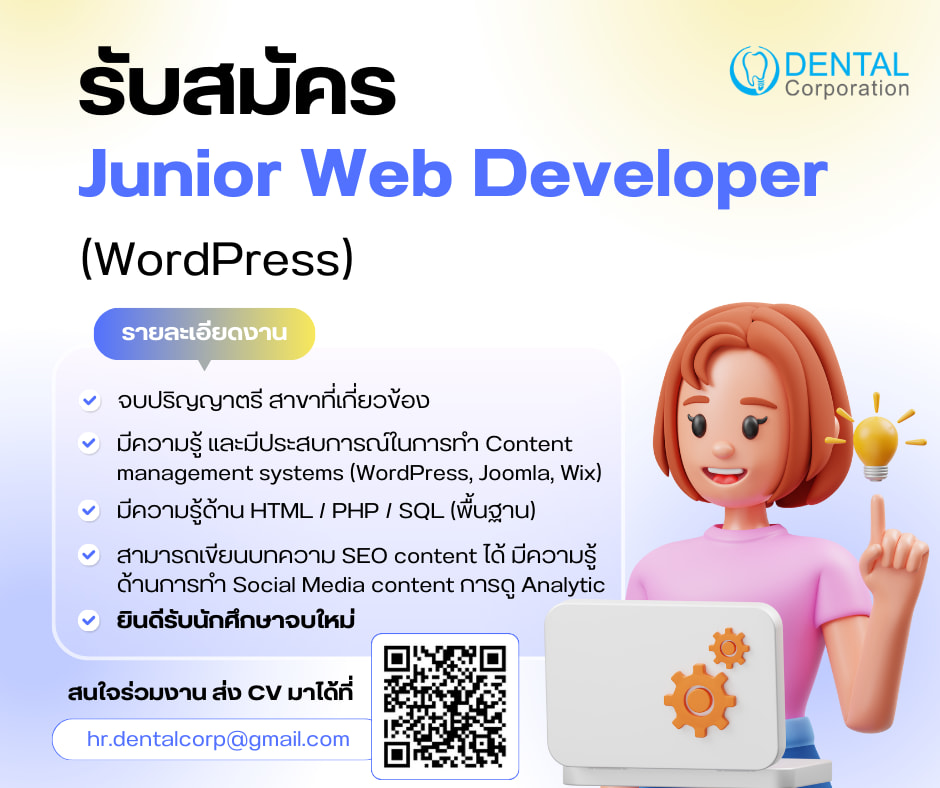

In [ ]:
from IPython.display import HTML

job_name = 'Junior Web Dev'

llm_response = extract_skill_from_image('webdev_job.jpg')

print(f'LLM: Required Skills of "{job_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_job(job_name, skills)

paths = find_course_job_paths(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

  to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

  for k, v in results.items():
    to_be_print.append(f'💠 <b>{k}</b> :')
    for item in v:
      to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

  to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
  for k, v in required_skills_checklist.items():
    to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))

Uploaded file 'webdev_job.jpg' as: https://generativelanguage.googleapis.com/v1beta/files/f0y0nyebsv4x
Waiting for file processing...
...all files ready

LLM: Required Skills of "Junior Web Dev" :

{
    "skills": [
        "WordPress",
        "Joomla",
        "Wix",
        "HTML",
        "PHP",
        "SQL",
        "SEO content",
        "Social Media content",
        "Analytic"
    ]
}



Merge Required Skills of "Junior Web Dev":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "wordpress" :

{
    "related_terms": [
        "wordpress",
        "wp",
        "word press",
        "self-hosted wordpress",
        "wordpress.org",
        "wordpress.com",
        "wp-admin",
        "gutenberg editor",
        "wordpress theme",
        "wordpress plugin",
        "wordpress cms"
    ]
}


Merge related terms of "wordpress":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "joomla" :

{
    "related_terms": [
        "joomla",
        "joomla!"
    ]
}


Merge related terms of "joomla":   0%|          | 0/2 [00:00<?, ?it/s]

LLM: Related Terms of "wix" :

{
    "related_terms": [
        "wix",
        "wix.com",
        "wix code",
        "wix editor",
        "website builder",
        "website platform"
    ]
}


Merge related terms of "wix":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "html" :

{
    "related_terms": [
        "html",
        "html5",
        "hypertext markup language",
        "markup language",
        "web page code",
        "html code"
    ]
}


Merge related terms of "html":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "php" :

{
    "related_terms": [
        "php",
        "hypertext preprocessor",
        "php7",
        "php8"
    ]
}


Merge related terms of "php":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Related Terms of "seo content" :

{
    "related_terms": [
        "seo content",
        "search engine optimization content",
        "seo",
        "search engine optimization",
        "content optimization",
        "search engine optimization copy",
        "organic content",
        "website content",
        "on-page optimization",
        "off-page optimization",
        "content marketing",
        "keyword research",
        "technical seo"
    ]
}


Merge related terms of "seo content":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "social media content" :

{
    "related_terms": [
        "social media content",
        "social media posts",
        "social content",
        "content",
        "posts",
        "media",
        "online content",
        "social media",
        "sm",
        "socmed"
    ]
}


Merge related terms of "social media content":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "analytic" :

{
    "related_terms": [
        "analytic",
        "analytics",
        "analytical",
        "data analytic",
        "data analytics",
        "statistical analysis",
        "business analytics",
        "predictive analytics",
        "prescriptive analytics",
        "descriptive analytics",
        "diagnostic analytics",
        "data analysis",
        "quantitative analysis",
        "qualitative analysis",
        "bi",
        "business intelligence"
    ]
}


Merge related terms of "analytic":   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML

job_name = 'Software Engineer at Ngernturbo'

url = "https://th.jobsdb.com/th/job/80988824?ref=search-standalone&type=standout&origin=showNewTab#sol=864fc0a4c9e565d4085181d9e0c989e4e7fa3c85"
html_content = get_html_content(url)
scraped_job_description = get_job_ad_details(html_content)

llm_response = extract_skill_from_text(scraped_job_description)

print(f'LLM: Required Skills of "{job_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_job(job_name, skills)

paths = find_course_job_paths(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

  to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

  for k, v in results.items():
    to_be_print.append(f'💠 <b>{k}</b> :')
    for item in v:
      to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

  to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
  for k, v in required_skills_checklist.items():
    to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))

LLM: Required Skills of "Software Engineer at Ngernturbo" :

{
    "skills": [
        "problem solving",
        "collaboration",
        "adaptability",
        "communication",
        "design",
        "development",
        "testing",
        "monitoring",
        "scaling applications",
        "Agile",
        "coding",
        "database design",
        "unit testing",
        "regression testing",
        "system testing"
    ]
}



Merge Required Skills of "Software Engineer at Ngernturbo":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Related Terms of "problem solving" :

{
    "related_terms": [
        "problem solving",
        "troubleshooting",
        "debugging",
        "root cause analysis",
        "rca",
        "issue resolution",
        "incident management",
        "problem determination",
        "defect resolution",
        "solutioning",
        "problem analysis"
    ]
}


Merge related terms of "problem solving":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "adaptability" :

{
    "related_terms": [
        "adaptability",
        "flexibility",
        "scalability",
        "extensibility",
        "adaptable",
        "flexible",
        "scalable",
        "extensible",
        "modifiable",
        "configurable",
        "customizable"
    ]
}


Merge related terms of "adaptability":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "communication" :

{
    "related_terms": [
        "communication",
        "comms",
        "inter-process communication",
        "ipc",
        "messaging",
        "signaling",
        "data transfer",
        "data exchange",
        "network communication",
        "api",
        "application programming interface",
        "rpc",
        "remote procedure call",
        "socket",
        "inter-thread communication",
        "itc",
        "signal",
        "message queue",
        "pubsub",
        "publish subscribe"
    ]
}


Merge related terms of "communication":   0%|          | 0/20 [00:00<?, ?it/s]

LLM: Related Terms of "development" :

{
    "related_terms": [
        "development",
        "dev",
        "software development",
        "application development",
        "web development",
        "mobile development",
        "game development",
        "system development",
        "software engineering",
        "coding",
        "programming",
        "design",
        "implementation",
        "build",
        "deploy",
        "testing",
        "debugging",
        "maintenance"
    ]
}


Merge related terms of "development":   0%|          | 0/18 [00:00<?, ?it/s]

LLM: Related Terms of "scaling applications" :

{
    "related_terms": [
        "scaling applications",
        "application scaling",
        "scaling",
        "horizontal scaling",
        "vertical scaling",
        "scale up",
        "scale out",
        "capacity planning",
        "load balancing",
        "distributed systems",
        "high availability",
        "fault tolerance",
        "elasticity",
        "auto scaling",
        "cloud scaling",
        "microservices architecture"
    ]
}


Merge related terms of "scaling applications":   0%|          | 0/16 [00:00<?, ?it/s]

LLM: Related Terms of "agile" :

{
    "related_terms": [
        "agile",
        "agile software development",
        "agile methodologies",
        "scrum",
        "kanban",
        "xp",
        "extreme programming",
        "lean software development",
        "iterative development",
        "incremental development",
        "adaptive software development",
        "asd",
        "agile project management"
    ]
}


Merge related terms of "agile":   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML

job_name = 'Full Stack JavaScript'

url = "https://th.jobsdb.com/th/job/80955640?ref=search-standalone&type=standout&origin=showNewTab#sol=c81feeae352d44886336c42bbcf29a49e6d90732"
html_content = get_html_content(url)
scraped_job_description = get_job_ad_details(html_content)

llm_response = extract_skill_from_text(scraped_job_description)

print(f'LLM: Required Skills of "{job_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_job(job_name, skills)

paths = find_course_job_paths(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

  to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

  for k, v in results.items():
    to_be_print.append(f'💠 <b>{k}</b> :')
    for item in v:
      to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

  to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
  for k, v in required_skills_checklist.items():
    to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))

LLM: Required Skills of "Full Stack JavaScript" :

{
    "skills": [
        "Javascript",
        "Nodejs",
        "Nextjs",
        "React",
        "Typescript",
        "GraphQL",
        "Scrum",
        "MongoDB",
        "git",
        "CI/CD",
        "Fullstack",
        "Frontend",
        "Backend"
    ]
}



Merge Required Skills of "Full Stack JavaScript":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "javascript" :

{
    "related_terms": [
        "javascript",
        "js",
        "ecma script",
        "ecmascript",
        "jscript"
    ]
}


Merge related terms of "javascript":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "nodejs" :

{
    "related_terms": [
        "nodejs",
        "node.js",
        "node",
        "javascript runtime",
        "server-side javascript"
    ]
}


Merge related terms of "nodejs":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "nextjs" :

{
    "related_terms": [
        "nextjs",
        "next.js",
        "next js",
        "react framework",
        "server-side rendering framework",
        "ssr framework",
        "static site generation framework",
        "ssg framework",
        "next js framework"
    ]
}


Merge related terms of "nextjs":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "react" :

{
    "related_terms": [
        "react",
        "react.js",
        "reactjs",
        "react library",
        "react framework",
        "js library",
        "user interface library",
        "ui library"
    ]
}


Merge related terms of "react":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "typescript" :

{
    "related_terms": [
        "typescript",
        "ts",
        "type script"
    ]
}


Merge related terms of "typescript":   0%|          | 0/3 [00:00<?, ?it/s]

LLM: Related Terms of "graphql" :

{
    "related_terms": [
        "graphql",
        "graph ql",
        "graphql query language",
        "query language",
        "graphql schema",
        "schema",
        "graphql api",
        "api",
        "graphql server",
        "server",
        "graphql client",
        "client",
        "subscriptions"
    ]
}


Merge related terms of "graphql":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "mongodb" :

{
    "related_terms": [
        "mongodb",
        "mongo",
        "mongodb database",
        "nosql database",
        "document database"
    ]
}


Merge related terms of "mongodb":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "git" :

{
    "related_terms": [
        "git",
        "git bash",
        "distributed version control system",
        "dvcs",
        "version control",
        "source code management",
        "scm"
    ]
}


Merge related terms of "git":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "fullstack" :

{
    "related_terms": [
        "fullstack",
        "full stack",
        "full-stack",
        "fullstack developer",
        "full stack developer",
        "full-stack developer",
        "fullstack web developer",
        "full stack web developer",
        "full-stack web developer"
    ]
}


Merge related terms of "fullstack":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "frontend" :

{
    "related_terms": [
        "frontend",
        "front end",
        "client side",
        "user interface",
        "ui",
        "ux",
        "user experience",
        "frontend development",
        "front end development",
        "client-side development"
    ]
}


Merge related terms of "frontend":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "backend" :

{
    "related_terms": [
        "backend",
        "back-end",
        "server-side",
        "server",
        "api",
        "application programming interface",
        "rest",
        "restful",
        "database",
        "db",
        "sql",
        "nosql",
        "back end development",
        "server-side development"
    ]
}


Merge related terms of "backend":   0%|          | 0/14 [00:00<?, ?it/s]

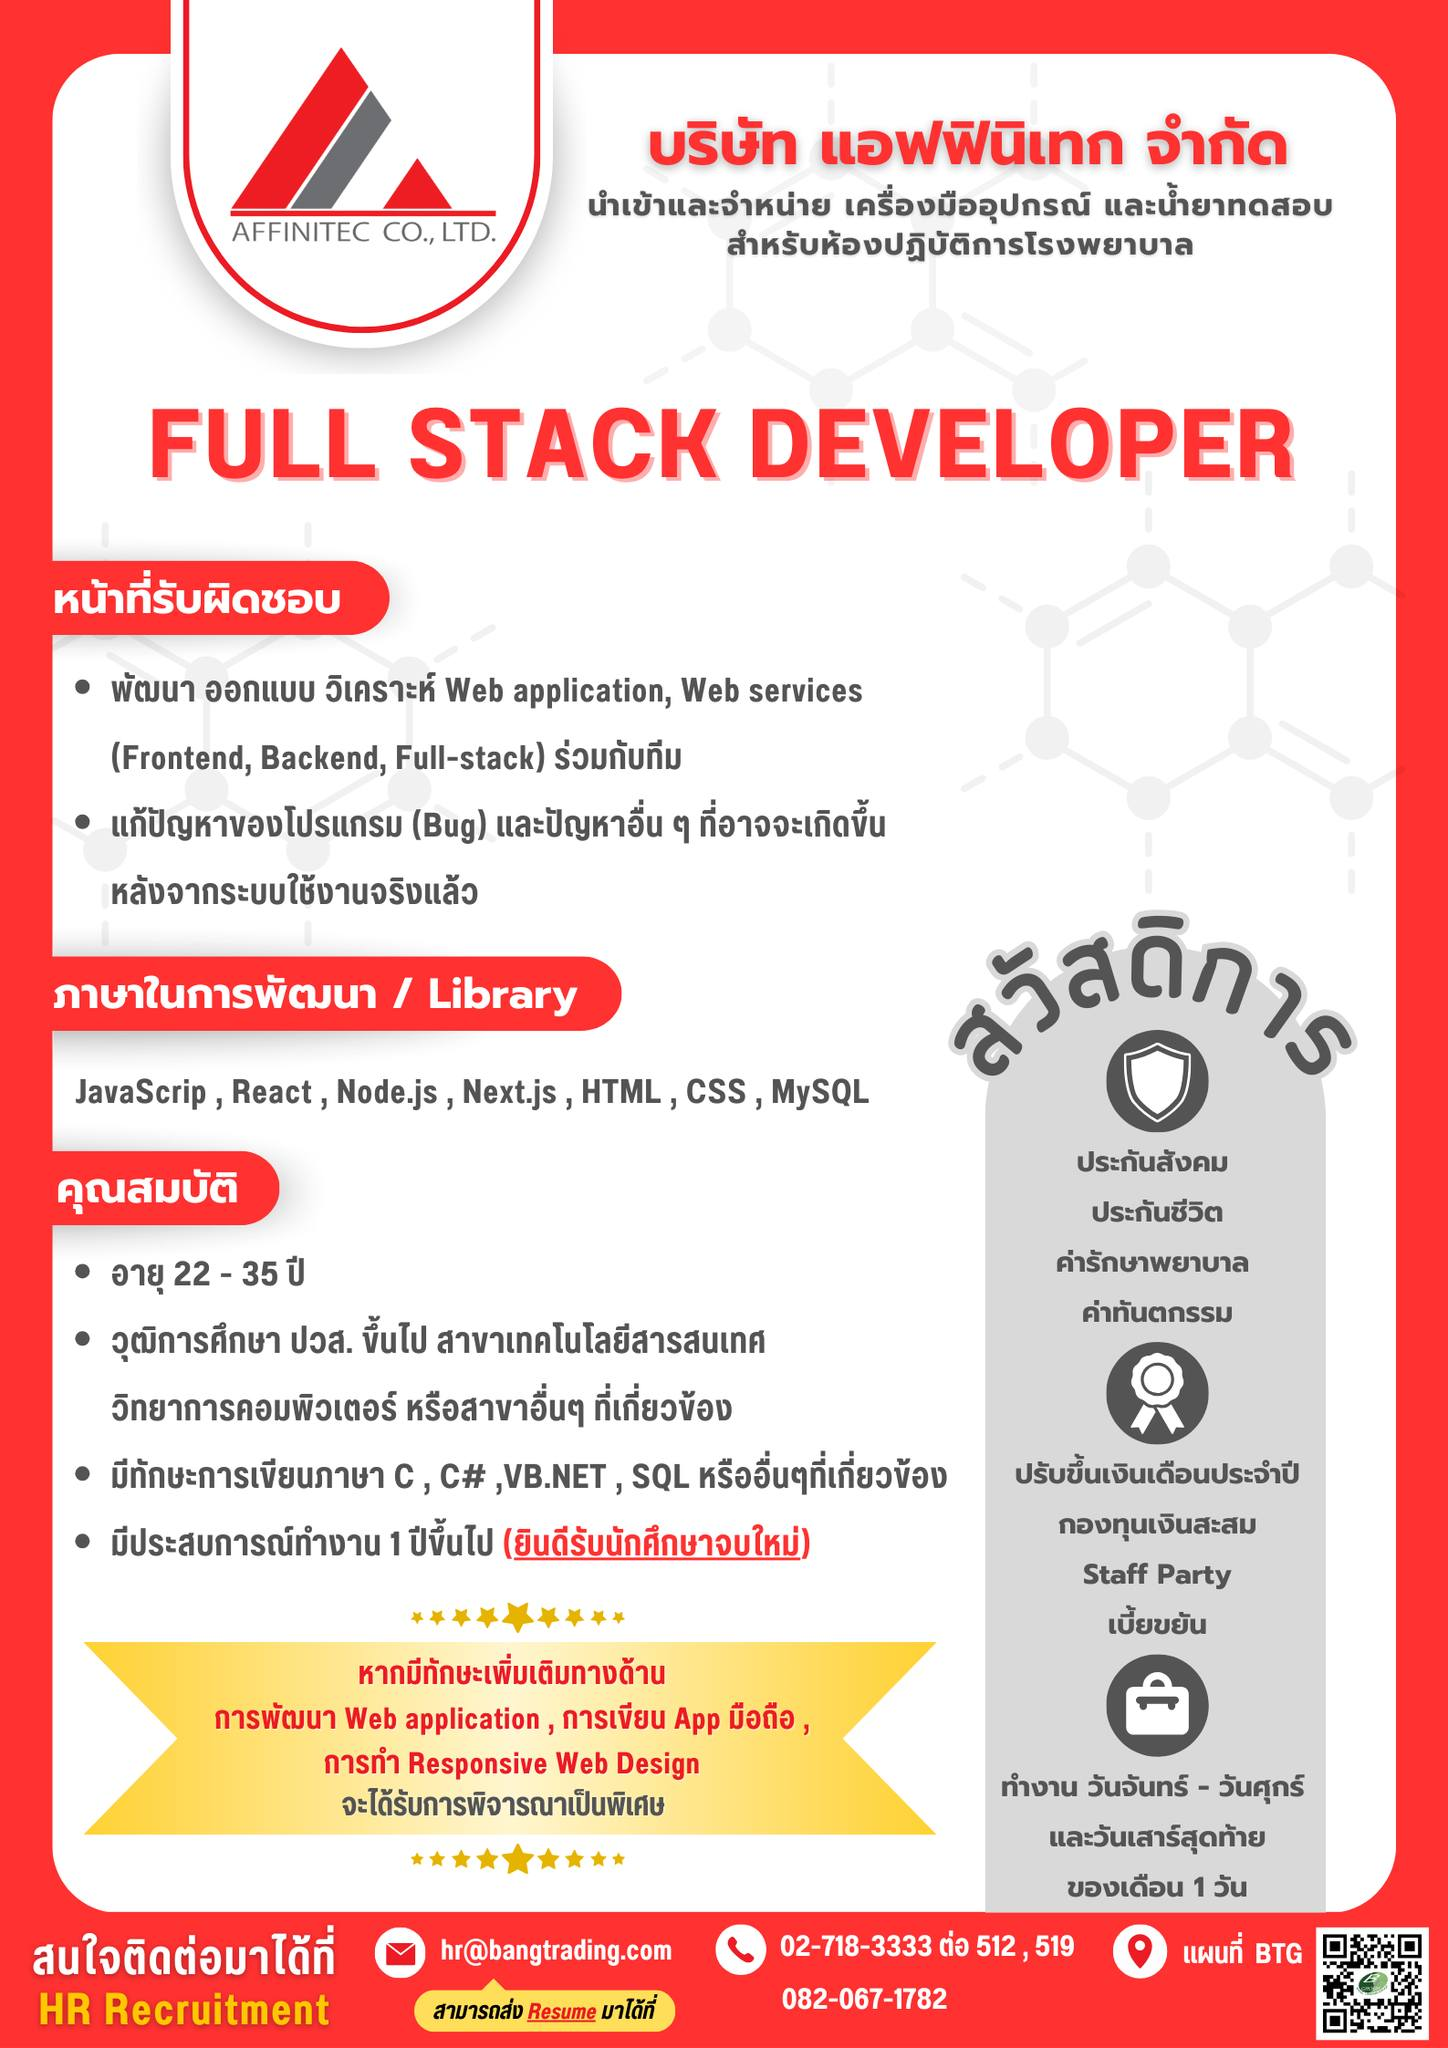

In [ ]:
from IPython.display import HTML

job_name = 'Full Stack at AFFINITEC'

llm_response = extract_skill_from_image('fullstack_job.jpg')

print(f'LLM: Required Skills of "{job_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_job(job_name, skills)

paths = find_course_job_paths(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

  to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

  for k, v in results.items():
    to_be_print.append(f'💠 <b>{k}</b> :')
    for item in v:
      to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

  to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
  for k, v in required_skills_checklist.items():
    to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))

Uploaded file 'fullstack_job.jpg' as: https://generativelanguage.googleapis.com/v1beta/files/6yzrqqeivd6l
Waiting for file processing...
...all files ready

LLM: Required Skills of "Full Stack at AFFINITEC" :

{
    "skills": [
        "JavaScript",
        "React",
        "Node.js",
        "Next.js",
        "HTML",
        "CSS",
        "MySQL",
        "C",
        "C#",
        "VB.NET",
        "SQL"
    ]
}



Merge Required Skills of "Full Stack at AFFINITEC":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "css" :

{
    "css_terms": [
        "css",
        "cascading style sheets",
        "stylesheets",
        "css3",
        "style sheet"
    ]
}


Merge related terms of "css":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "mysql" :

{
    "related_terms": [
        "mysql",
        "mysql database",
        "my sql",
        "relational database management system",
        "rdbms",
        "sql database"
    ]
}


Merge related terms of "mysql":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "c" :

{
    "related_terms": [
        "c",
        "c language",
        "c programming",
        "c programming language"
    ]
}


Merge related terms of "c":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Related Terms of "c#" :

{
    "related_terms": [
        "c#",
        "c sharp",
        "csharp",
        "microsoft c#"
    ]
}


Merge related terms of "c#":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Related Terms of "vb.net" :

{
    "related_terms": [
        "vb.net",
        "visual basic .net",
        "vb",
        "visual basic"
    ]
}


Merge related terms of "vb.net":   0%|          | 0/4 [00:00<?, ?it/s]

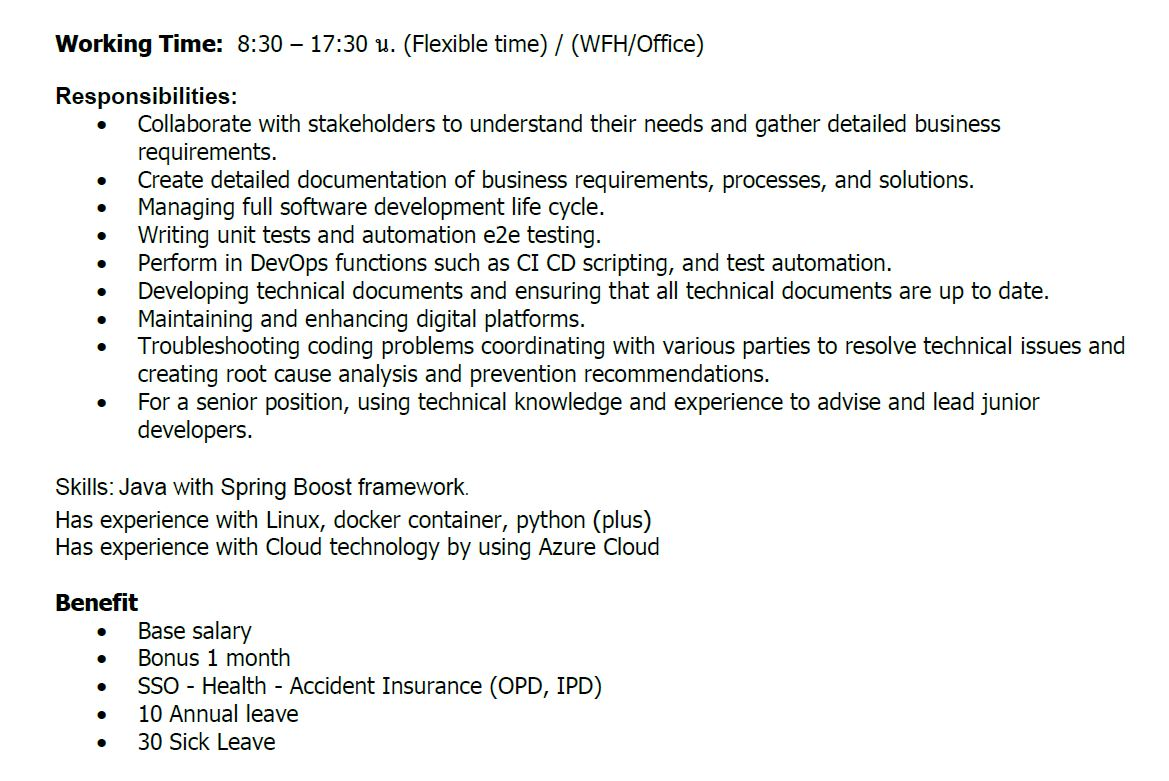

In [ ]:
from IPython.display import HTML

job_name = 'Java Dev at PRTR'

llm_response = extract_skill_from_image('java_dev_job.jpg')

print(f'LLM: Required Skills of "{job_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_job(job_name, skills)

paths = find_course_job_paths(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

  to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

  for k, v in results.items():
    to_be_print.append(f'💠 <b>{k}</b> :')
    for item in v:
      to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

  to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
  for k, v in required_skills_checklist.items():
    to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))

Uploaded file 'java_dev_job.jpg' as: https://generativelanguage.googleapis.com/v1beta/files/pn97lk8151fl
Waiting for file processing...
...all files ready

LLM: Required Skills of "Java Dev at PRTR" :

{
    "skills": [
        "Java",
        "Spring Boot",
        "Linux",
        "docker",
        "python",
        "Azure Cloud"
    ]
}



Merge Required Skills of "Java Dev at PRTR":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "spring boot" :

{
    "related_terms": [
        "spring boot",
        "springboot",
        "spring",
        "spring framework",
        "microservices framework",
        "java framework",
        "rest api framework"
    ]
}


Merge related terms of "spring boot":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "azure cloud" :

{
    "azure_cloud_terms": [
        "azure",
        "microsoft azure",
        "azure cloud",
        "windows azure",
        "cloud computing",
        "microsoft cloud"
    ]
}


Merge related terms of "azure cloud":   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
course_name = 'CN310 Computer Server Configuration'

course_description = '''Modifies server configuration to support enterprise service : domain name server,File
transfer,Web,Email,Database server,Linux.'''

llm_response = extract_skill_from_text(course_description)

print(f'LLM: Included Skills of "{course_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_course(course_name, skills)

LLM: Included Skills of "CN310 Computer Server Configuration" :

{
    "skills": [
        "DNS",
        "File Transfer",
        "Web Server",
        "Email Server",
        "Database Server",
        "Linux"
    ]
}



Merge Included Skills of "CN310 Computer Server Configuration":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "file transfer" :

{
    "related_terms": [
        "file transfer",
        "file transfer protocol",
        "ftp",
        "sftp",
        "ftps",
        "file sharing",
        "data transfer",
        "file exchange",
        "file upload",
        "file download",
        "file copy",
        "data transmission"
    ]
}


Merge related terms of "file transfer":   0%|          | 0/12 [00:00<?, ?it/s]

LLM: Related Terms of "email server" :

{
    "related_terms": [
        "email server",
        "mail server",
        "smtp server",
        "pop3 server",
        "imap server",
        "mail transfer agent",
        "mta",
        "message transfer agent",
        "email server software",
        "mail server software"
    ]
}


Merge related terms of "email server":   0%|          | 0/10 [00:00<?, ?it/s]

LLM: Related Terms of "database server" :

{
    "related_terms": [
        "database server",
        "db server",
        "database management system server",
        "dbms server",
        "sql server",
        "relational database server",
        "rdbms server",
        "nosql database server",
        "database instance",
        "db instance"
    ]
}


Merge related terms of "database server":   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML

job_name = 'Java SpringBoot Dev'

# llm_response = extract_skill_from_image('java_dev_job.jpg')

# print(f'LLM: Required Skills of "{job_name}" :\n')
# pprint(llm_response)
# print()

# skills = llm_response['skills']

# add_new_job(job_name, skills)

paths = find_course_job_paths(job_name)
paths2 = find_course_job_paths2(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

if paths2:
  for path in paths2:
    course_name, description, skill1 = describe_course_job_path2(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill1] = True

to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

for k, v in results.items():
  to_be_print.append(f'💠 <b>{k}</b> :')
  for item in v:
    to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
for k, v in required_skills_checklist.items():
  to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))

In [ ]:
from IPython.display import HTML

job_name = 'Java Dev at PRTR'

# llm_response = extract_skill_from_image('java_dev_job.jpg')

# print(f'LLM: Required Skills of "{job_name}" :\n')
# pprint(llm_response)
# print()

# skills = llm_response['skills']

# add_new_job(job_name, skills)

paths = find_course_job_paths(job_name)
paths2 = find_course_job_paths2(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

if paths2:
  for path in paths2:
    course_name, description, skill1 = describe_course_job_path2(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill1] = True

to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

for k, v in results.items():
  to_be_print.append(f'💠 <b>{k}</b> :')
  for item in v:
    to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
for k, v in required_skills_checklist.items():
  to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))

In [ ]:
from IPython.display import HTML

job_name = 'Business Analyst'

llm_response = extract_skill_from_image('ba_job.jpg')

print(f'LLM: Required Skills of "{job_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_job(job_name, skills)

paths = find_course_job_paths(job_name)
paths2 = find_course_job_paths2(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

if paths2:
  for path in paths2:
    course_name, description, skill1 = describe_course_job_path2(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill1] = True

to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

for k, v in results.items():
  to_be_print.append(f'💠 <b>{k}</b> :')
  for item in v:
    to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
for k, v in required_skills_checklist.items():
  to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))

Uploaded file 'ba_job.jpg' as: https://generativelanguage.googleapis.com/v1beta/files/mwuekkdnwx0b
Waiting for file processing...
...all files ready

LLM: Required Skills of "Business Analyst" :

{
    "skills": [
        "Business/System Analyst",
        "application development",
        "waterfall",
        "Agile",
        "database management",
        "MySQL",
        "SQL",
        "communication in English"
    ]
}



Merge Required Skills of "Business Analyst":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "business/system analyst" :

{
    "related_terms": [
        "business analyst",
        "ba",
        "systems analyst",
        "sa",
        "business systems analyst",
        "data analyst",
        "requirements analyst",
        "process analyst",
        "management consultant",
        "it consultant",
        "software analyst"
    ]
}


Merge related terms of "business/system analyst":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "waterfall" :

{
    "related_terms": [
        "waterfall",
        "waterfall model",
        "linear sequential model",
        "waterfall methodology"
    ]
}


Merge related terms of "waterfall":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Related Terms of "communication in english" :

{
    "related_terms": [
        "communication",
        "english",
        "comms",
        "communication skills",
        "verbal communication",
        "written communication",
        "nonverbal communication",
        "technical communication",
        "business communication",
        "cross-cultural communication",
        "collaboration",
        "coordination",
        "interaction",
        "dialogue",
        "discussion",
        "conversation",
        "messaging",
        "email",
        "chat",
        "video conferencing",
        "documentation"
    ]
}


Merge related terms of "communication in english":   0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML

job_name = 'Software Tester at Ekkremis'

llm_response = extract_skill_from_image('tester.jpg')

print(f'LLM: Required Skills of "{job_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_job(job_name, skills)

paths = find_course_job_paths(job_name)
paths2 = find_course_job_paths2(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

if paths2:
  for path in paths2:
    course_name, description, skill1 = describe_course_job_path2(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill1] = True

to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

for k, v in results.items():
  to_be_print.append(f'💠 <b>{k}</b> :')
  for item in v:
    to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
for k, v in required_skills_checklist.items():
  to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))

Uploaded file 'tester.jpg' as: https://generativelanguage.googleapis.com/v1beta/files/wzy93zu6jgwp
Waiting for file processing...
...all files ready

LLM: Required Skills of "Software Tester at Ekkremis" :

{
    "skills": [
        "Frontend",
        "mobile",
        "web",
        "Backend",
        "database",
        "Design Test Cases",
        "Test Case",
        "Test Script",
        "Requirement",
        "System and Integration Testing",
        "User Manual",
        "Manual Tester",
        "API",
        "SQL"
    ]
}



Merge Required Skills of "Software Tester at Ekkremis":   0%|          | 0/14 [00:00<?, ?it/s]

LLM: Related Terms of "mobile" :

{
    "mobile_terms": [
        "mobile",
        "mobile device",
        "mobile phone",
        "cell phone",
        "smartphone",
        "handheld",
        "pocket pc",
        "cell",
        "mobile app",
        "app",
        "m-commerce",
        "mobile commerce",
        "handset"
    ]
}


Merge related terms of "mobile":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "web" :

{
    "related_terms": [
        "web",
        "www",
        "world wide web",
        "internet",
        "online",
        "webpage",
        "website",
        "web application",
        "web app",
        "web server",
        "web development",
        "web design",
        "web technology",
        "web based",
        "web portal",
        "web service",
        "web 2.0",
        "web 3.0",
        "web browser",
        "browser"
    ]
}


Merge related terms of "web":   0%|          | 0/20 [00:00<?, ?it/s]

LLM: Related Terms of "design test cases" :

{
    "related_terms": [
        "design test cases",
        "test case design",
        "test case development",
        "create test cases",
        "design test scenarios",
        "test design",
        "tc design",
        "test case",
        "test scenario"
    ]
}


Merge related terms of "design test cases":   0%|          | 0/9 [00:00<?, ?it/s]

LLM: Related Terms of "requirement" :

{
    "related_terms": [
        "requirement",
        "requirements",
        "reqs",
        "need",
        "condition",
        "functional requirement",
        "non-functional requirement",
        "user requirement",
        "system requirement",
        "business requirement",
        "specification",
        "criteria",
        "constraints",
        "must-have",
        "should-have",
        "could-have",
        "user story",
        "epic"
    ]
}


Merge related terms of "requirement":   0%|          | 0/18 [00:00<?, ?it/s]

LLM: Related Terms of "system and integration testing" :

{
    "related_terms": [
        "system testing",
        "integration testing",
        "system and integration testing",
        "end-to-end testing",
        "e2e testing",
        "sit",
        "component integration testing",
        "system integration testing",
        "functional testing",
        "black box testing",
        "integration and system testing"
    ]
}


Merge related terms of "system and integration testing":   0%|          | 0/11 [00:00<?, ?it/s]

LLM: Related Terms of "user manual" :

{
    "related_terms": [
        "user manual",
        "user guide",
        "instruction manual",
        "instruction guide",
        "how-to guide",
        "quick start guide",
        "reference manual",
        "end-user documentation",
        "user documentation",
        "manual",
        "guide",
        "documentation"
    ]
}


Merge related terms of "user manual":   0%|          | 0/12 [00:00<?, ?it/s]

LLM: Related Terms of "manual tester" :

{
    "related_terms": [
        "manual tester",
        "tester",
        "qa tester",
        "quality assurance tester",
        "software tester",
        "test engineer",
        "sdrt",
        "sdet",
        "test analyst",
        "quality analyst",
        "verification and validation engineer"
    ]
}


Merge related terms of "manual tester":   0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML

job_name = 'Java Dev at PRTR'

# llm_response = extract_skill_from_image('java_dev_job.jpg')

# print(f'LLM: Required Skills of "{job_name}" :\n')
# pprint(llm_response)
# print()

# skills = llm_response['skills']

# add_new_job(job_name, skills)

paths = find_course_job_paths(job_name)
paths2 = find_course_job_paths2(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

if paths2:
  for path in paths2:
    course_name, description, skill1 = describe_course_job_path2(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill1] = True

to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

for k, v in results.items():
  to_be_print.append(f'💠 <b>{k}</b> :')
  for item in v:
    to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
for k, v in required_skills_checklist.items():
  to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))

# Test

## Add New Job (Image)

In [ ]:
job_name = 'testjob002'

llm_response = extract_skill_from_image('workpoint.jpg')

print(f'LLM: Required Skills of "{job_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_job(job_name, skills)

Uploaded file 'workpoint.jpg' as: https://generativelanguage.googleapis.com/v1beta/files/fyo71g1b9x2g
Waiting for file processing...
...all files ready

LLM: Required Skills of "testjob002" :

{
    "skills": [
        "PHP",
        "XML",
        "JavaScript",
        "CSS",
        "HTML",
        "JSON",
        "AJAX",
        "jQuery",
        "API Service",
        "Web Service"
    ]
}



Merge Required Skills of "testjob002":   0%|          | 0/10 [00:00<?, ?it/s]

## Add New Job (JobsDB Link)

In [ ]:
job_name = 'testjob004'

url = "https://th.jobsdb.com/th/job/81224382?ref=search-standalone&type=standout&origin=showNewTab#sol=ed066d1e3f0876b340b9f480f31ca316adb7de44"
html_content = get_html_content(url)
scraped_job_description = get_job_ad_details(html_content)

llm_response = extract_skill_from_text(scraped_job_description)

print(f'LLM: Required Skills of "{job_name}" :\n')
pprint(llm_response)
print()

skills = llm_response['skills']

add_new_job(job_name, skills)

LLM: Required Skills of "testjob004" :

{
    "skills": [
        "PHP",
        "HTML",
        "Javascript",
        "CSS",
        "MVC",
        "HMVC",
        "MySQL",
        "Linux",
        "Git",
        "Gitflow",
        "NoSQL",
        "Nodejs",
        "NPM",
        "Vuejs",
        "Angularjs",
        "React",
        "Ionic Framework",
        "Capacitorjs",
        "cache",
        "application caching",
        "database caching",
        "problem solving",
        "performance optimization",
        "time management",
        "communication",
        "Google Sheet",
        "Calculus",
        "Probability",
        "Statistics",
        "Algebra",
        "Logarithms",
        "Exponents"
    ]
}



Merge Required Skills of "testjob004":   0%|          | 0/32 [00:00<?, ?it/s]

LLM: Related Terms of "gitflow" :

{
    "related_terms": [
        "gitflow",
        "git branching model",
        "gitflow workflow",
        "branching model",
        "workflow"
    ]
}


Merge related terms of "gitflow":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "npm" :

{
    "related_terms": [
        "npm",
        "node package manager",
        "node packages",
        "npm install",
        "npm uninstall",
        "npm update",
        "npm registry"
    ]
}


Merge related terms of "npm":   0%|          | 0/7 [00:00<?, ?it/s]

LLM: Related Terms of "vuejs" :

{
    "related_terms": [
        "vuejs",
        "vue",
        "vue.js",
        "progressive javascript framework"
    ]
}


Merge related terms of "vuejs":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Related Terms of "angularjs" :

{
    "related_terms": [
        "angularjs",
        "angular",
        "ajs",
        "angular.js"
    ]
}


Merge related terms of "angularjs":   0%|          | 0/4 [00:00<?, ?it/s]

LLM: Related Terms of "ionic framework" :

{
    "related_terms": [
        "ionic",
        "ionic framework",
        "ionic v1",
        "ionic v2",
        "ionic v3",
        "ionic v4",
        "ionic v5",
        "ionic v6",
        "ionic react",
        "ionic angular",
        "ionic capacitor",
        "ionic native",
        "hybrid mobile app development",
        "mobile app framework",
        "cross-platform mobile development"
    ]
}


Merge related terms of "ionic framework":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Related Terms of "capacitorjs" :

{
    "related_terms": [
        "capacitorjs",
        "capacitor",
        "capacitor framework",
        "ionic capacitor",
        "cordova alternative",
        "hybrid mobile app framework"
    ]
}


Merge related terms of "capacitorjs":   0%|          | 0/6 [00:00<?, ?it/s]

LLM: Related Terms of "cache" :

{
    "related_terms": [
        "cache",
        "caches",
        "caching",
        "cache memory",
        "cpu cache",
        "disk cache",
        "memory cache",
        "web cache",
        "browser cache",
        "cache server",
        "cdn",
        "content delivery network"
    ]
}


Merge related terms of "cache":   0%|          | 0/12 [00:00<?, ?it/s]

LLM: Related Terms of "application caching" :

{
    "related_terms": [
        "application caching",
        "caching",
        "app caching",
        "browser caching",
        "web caching",
        "cache",
        "http caching",
        "content delivery network (cdn)",
        "cdn",
        "offline access",
        "local storage",
        "data caching",
        "response caching",
        "aggressive caching",
        "cache control",
        "cache-control headers"
    ]
}


Merge related terms of "application caching":   0%|          | 0/16 [00:00<?, ?it/s]

LLM: Related Terms of "database caching" :

{
    "related_terms": [
        "database caching",
        "db caching",
        "cache",
        "caching",
        "data caching",
        "database cache",
        "query caching",
        "result set caching",
        "page caching",
        "fragment caching",
        "object caching",
        "in-memory caching"
    ]
}


Merge related terms of "database caching":   0%|          | 0/12 [00:00<?, ?it/s]

LLM: Related Terms of "performance optimization" :

{
    "related_terms": [
        "performance optimization",
        "performance tuning",
        "optimization",
        "perf optimization",
        "perf tuning",
        "system tuning",
        "application tuning",
        "database tuning",
        "code optimization",
        "query optimization",
        "response time optimization",
        "latency optimization",
        "throughput optimization",
        "scalability optimization",
        "resource optimization",
        "memory optimization",
        "cpu optimization",
        "io optimization",
        "network optimization",
        "throughput improvement",
        "response time improvement",
        "latency reduction",
        "performance improvement",
        "efficiency improvement"
    ]
}


Merge related terms of "performance optimization":   0%|          | 0/24 [00:00<?, ?it/s]

LLM: Related Terms of "time management" :

{
    "related_terms": [
        "time management",
        "task management",
        "project management",
        "timeboxing",
        "pomodoro",
        "agile",
        "kanban",
        "scrum",
        "prioritization",
        "scheduling",
        "deadlines",
        "estimation",
        "sprint planning",
        "work breakdown structure",
        "wbs"
    ]
}


Merge related terms of "time management":   0%|          | 0/15 [00:00<?, ?it/s]

LLM: Related Terms of "google sheet" :

{
    "related_terms": [
        "google sheets",
        "gsheets",
        "google spreadsheet",
        "spreadsheet",
        "online spreadsheet"
    ]
}


Merge related terms of "google sheet":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "calculus" :

{
    "related_terms": [
        "calculus",
        "mathematical analysis",
        "derivatives",
        "integrals",
        "differential equations",
        "numerical analysis",
        "optimization",
        "calc"
    ]
}


Merge related terms of "calculus":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "probability" :

{
    "related_terms": [
        "probability",
        "prob",
        "chance",
        "likelihood",
        "odds",
        "probability distribution",
        "probability density function",
        "pdf",
        "cumulative distribution function",
        "cdf",
        "random variable",
        "statistical probability",
        "stochastic probability"
    ]
}


Merge related terms of "probability":   0%|          | 0/13 [00:00<?, ?it/s]

LLM: Related Terms of "statistics" :

{
    "related_terms": [
        "statistics",
        "stats",
        "statistical analysis",
        "data analysis",
        "statistical modeling",
        "regression",
        "classification",
        "clustering",
        "statistical inference",
        "hypothesis testing",
        "probability",
        "distributions",
        "bayesian statistics",
        "frequentist statistics",
        "machine learning",
        "data science",
        "data mining",
        "predictive modeling"
    ]
}


Merge related terms of "statistics":   0%|          | 0/18 [00:00<?, ?it/s]

LLM: Related Terms of "algebra" :

{
    "related_terms": [
        "algebra",
        "linear algebra",
        "boolean algebra",
        "abstract algebra",
        "relational algebra"
    ]
}


Merge related terms of "algebra":   0%|          | 0/5 [00:00<?, ?it/s]

LLM: Related Terms of "logarithms" :

{
    "related_terms": [
        "logarithm",
        "log",
        "ln",
        "natural logarithm",
        "log base 10",
        "log10",
        "base 10 logarithm",
        "common logarithm"
    ]
}


Merge related terms of "logarithms":   0%|          | 0/8 [00:00<?, ?it/s]

LLM: Related Terms of "exponents" :

{
    "related_terms": [
        "exponent",
        "power",
        "index",
        "power of",
        "order of magnitude"
    ]
}


Merge related terms of "exponents":   0%|          | 0/5 [00:00<?, ?it/s]

## Job - Course Mapping

In [ ]:
from IPython.display import HTML

job_name = 'testjob004'

paths = find_course_job_paths(job_name)
paths2 = find_course_job_paths2(job_name)

results = {}
required_skills_checklist = {k:False for k in get_all_required_skills(job_name)}

to_be_print = []

if paths:
  for path in paths:
    course_name, description, skill2 = describe_course_job_path(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill2] = True

if paths2:
  for path in paths2:
    course_name, description, skill1 = describe_course_job_path2(path)
    if course_name in results:
      results[course_name].append(description)
    else:
      results[course_name] = [description]

    required_skills_checklist[skill1] = True

to_be_print.append(f'<b style="font-size:large;">[ผลการค้นหากราฟ 🔮✨]: งาน <span style="color:rgb(116,238,21);">{job_name}</span> ต้องการ Skills ที่เรียนได้จากวิชาดังต่อไปนี้ !!</b><br>')

for k, v in results.items():
  to_be_print.append(f'💠 <b>{k}</b> :')
  for item in v:
    to_be_print.append(f'&nbsp;&nbsp;&nbsp;&nbsp;- {item}')

to_be_print.append('<br><b style="font-size:large;">[ภาพรวมความเกี่ยวข้องกับวิชาที่มีสอนในสาขา Soft-EN 💻✨]:</b><br>')
for k, v in required_skills_checklist.items():
  to_be_print.append(f"&nbsp;&nbsp;&nbsp;&nbsp;{'🟩' if v else '⬛'}&nbsp;&nbsp;&nbsp;&nbsp;{'<b>' + k.title() + '</b>' if v else k.title()}")

HTML('<br>'.join(to_be_print))